# 본 프로젝트는 마르코프 국면 모델을 활용해 시장의 다양한 변수들을 이용해서 국면을 진단하고 해당 국면에 어떤 섹터가 아웃퍼폼하는지 알아보는 서비스입니다.



### 먼저 서비스를 준비하기 앞서 전반적인 금융시장의 현황을 살펴보았습니다. 저희가 관찰한 결과로는 개인투자자의 거래이익은 코로나 발생이후 증가를 하였지만, 잦은 매매로 인한 거래비용은 거래이익을 상회할 정도로 큰 것을 볼 수 있습니다. 

### 뿐만 아니라, 이런 개인투자자 중 절반이 본인이 평가하는 금융 지식수준이 상당히 낮은 것으로 평가하고 있습니다. 

### 세번째로는, 현재 ETF의 수요는 증가하고 있지만, 정작 많은 국내 데이터 제공 사이트에서는 ETF와 관련된 의미있는 통계 및 데이터를 제공해주는 곳은 드물었습니다. 

### 따라서 저희는 앞서 말씀드린 이 세가지 문제를 해결하고자 섹터 ETF를 이용한 서비스를 제안해보았습니다. 거시적 국면에 따라 어떤 ETF들이 과거 성과가 좋았는지의 자료를 제공해주는 서비스를 마련해보았습니다.


![output1.PNG](attachment:output1.PNG)

## 분석의 세부과정은 다음과 같습니다.

![output2.PNG](attachment:output2.PNG)

In [ ]:
import pandas as pd
import os
import time
from datetime import datetime
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
import statsmodels.api as sm
import FinanceDataReader as wb
import datetime
import numpy as np
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')
import FinanceDataReader as fdr
from pykrx import stock


## 우선, 국면데이터를 만드는 과정으로 시작합니다. 국면을 만들기위해서 필요한 데이터를 가져오는 코드입니다.

## 예시에서는 거시적데이터인 원달러 환율의 국면과 CRB index의 국면을 이용해서 총 4개의 국면을 만들것입니다.
## 각각의 변수를 밑의 방식대로 국면변수를 추출한 뒤 따로 저장을 시켜둬야합니다.

In [ ]:
# 정리해둔 파일에서 환율데이터를 가져옵니다.

all_data=pd.read_csv('데이터정리_일간비교.csv', encoding='cp949').set_index('Date')

header= all_data.index.tolist()
H= list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), header))
all_data.index= H
all_data.loc[all_data.duplicated()]
data=all_data.loc['2001':,'KRW/USD'].dropna()

KRW_data=data.copy()

In [ ]:
#다른 데이터를 불러오고 싶을 시, 사용되는 코드 fred 데이터나 다른 데이터를 이용해서 다른 거시적 변수의 국면들도 확인할 수 있기에 첨부해둡니다.

'''
df_null =  fdr.DataReader(['KORLOLITONOSTSAM'],  data_source='fred')
data=df_null.loc['2000':]
'''



"\ndf_null =  fdr.DataReader(['KORLOLITONOSTSAM'],  data_source='fred')\ndata=df_null.loc['2000':]\n"

In [ ]:
# CRB데이터를 가져옵니다.
all_data=pd.read_csv('com_data.csv', encoding='cp949')
all_data=all_data.T
all_data.columns=all_data.iloc[1,:]
all_data=all_data.iloc[2:,:]
header= all_data.index.tolist()

H= list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M"), header))
all_data.index= H
#all_data=all_data[::-1]
data=all_data

CRB_data=data.copy()

<AxesSubplot:>

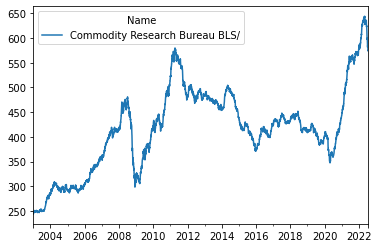

In [ ]:
data.plot()

## 데이터를 데이터프레임 형태로 넣어줘야합니다. NAN 값이 있으면 안되므로 주의하시길 바랍니다.

## 다음은 하나의 데이터를 국면분석해주는 클래스입니다. 자세한 사용방법은 아래에 있습니다.
## 모델은 marcov regime switching model을 활용했습니다.
## 링크 : https://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html

In [ ]:

class Regime_find:
    
    def __init__(self,data):
        #super().__init__(data,sector_data)
        print('국면분석 시작합니다.')
        self.data=data
        self.pct=0
    
    
    # 주기 변화 함수
    def change_freq(self,freq,data):
        
        data= data.asfreq(freq='d').ffill()
        data=data.rolling(20).mean().dropna()
        
        
        data=data.asfreq(freq=freq)
        
        inde=data.index
        
        data=pd.DataFrame(savgol_filter(np.array(data).reshape(-1),71, 3))
        data.index=inde
        
        
        
        
        return data
    
        
    
    # 변화율로 변경해주는 함수
    def data_pct_change(self,data):
        if self.pct ==0:
            pct_data=data.pct_change()
            pct_change=1
            return pct_data.dropna()
        else:
            return False
        
        
        
        
    def find_regime(self,data):
        regime_pd=self.regime_switching(data)

        return regime_pd
        



    # 국면분석 함수
    def regime_switching(self,data):

        for i in range(2,4):
            regime_num=i
            regime_model = sm.tsa.MarkovRegression(data, k_regimes=regime_num,switching_variance=True)
            
            regime_model_fit = regime_model.fit()

            print(regime_model_fit.summary())

            stat,profit_list,Log_lik = self.statistic_True(regime_model_fit,regime_num)

            if stat==True:
                #print(Log_lik)
                num_list=[0]*regime_num
                #print(num_list)
                num_list[profit_list.index(min(profit_list))]=-1
                num_list[profit_list.index(max(profit_list))]=1
                num_list


                regime_prob=regime_model_fit.smoothed_marginal_probabilities
                regime_prob.columns=num_list
                new_data=regime_prob.idxmax(axis=1)


                now_regime_list=[]
                now_regime=0
                for i in new_data:
                    if i ==1 or i==-1:
                        now_regime=i
                    now_regime_list.append(now_regime)
                
                regime_pd=pd.DataFrame(now_regime_list)
                regime_pd.index=regime_prob.index
                    



                return regime_pd


    # 통계치 확인 함수
    def statistic_True(self,res_kospi,regime_num):
        
        
        res_kospi.summary().tables[0]
        k=1
        profit_list=[]
        #print(regime_num,'국면')
        while k<regime_num+2:

            stat=pd.read_html(res_kospi.summary().tables[k].as_html())[0]
            stat.columns=stat.iloc[0,:]
            stat=stat.iloc[1:,:]

            Log_lik,AIC=pd.read_html(res_kospi.summary().tables[0].as_html())[0].iloc[1:3,3]

            

            z=stat.loc[1:,'P>|z|']


            #print(stat.coef)
            if k<regime_num+1:
                profit=stat.coef.iloc[0]
                #variance=stat.coef.iloc[1]

                profit_list.append(profit)

            if any(i>=0.3 for i in [z.values.astype(np.float64)[0]]):
                #print(z.values.astype(np.float64))
                print('통계치오류')
                return False,profit_list,Log_lik
                #break
            k+=1
            
        if len(profit_list)==0:
            return False,profit_list,Log_lik
        
            
        
        return True,profit_list,Log_lik
    
    
    
    # 국면 백테스팅 함수
    def backtesting(self,data,start,week):
        now_regime_list=[]
        day_list=[]
        last_day=data.index[-1]
        start_day=start
        #last_day=datetime.datetime.strptime(last_day, "%Y-%m-%d")
        try:
            start_day=datetime.datetime.strptime(start, "%Y-%m-%d")
            first=start_day
        except:
            print('형식 오류')
            return False
        print(start_day)
        
        
        diff=0
        while start_day < last_day:
            data_stop=data.loc[:start_day]
            #print('시작',data_stop)
            print('d',start_day)
            
            if start_day==first :
                last_regime =self.now_regime(data=data_stop,week=week)
            
            now_regime=self.now_regime(data_stop,week=week)
            
            if now_regime == 0 :
                now_regime=last_regime
        
            
            start_day+= datetime.timedelta(weeks=week)
            
            #now_regime_list.append(now_regime)
            
            
            if now_regime == last_regime:
                now_regime_list.append(now_regime)
                diff=0
            elif now_regime !=last_regime and diff==1:
                now_regime_list.append(now_regime)
                diff=0
            else:
                now_regime_list.append(last_regime)
                #print(last_regime)
                diff=1
            last_regime=now_regime
             
            
            day_list.append(start_day)
            
        predict_value=pd.DataFrame(now_regime_list,day_list)
        
        return predict_value
    
    # 현재 국면 확인 함수
    def now_regime(self,data,week):
        
        m_data=self.change_freq(str(week)+'w-fri',data)
        m_data2=self.data_pct_change(m_data)
        
        regime_data=self.find_regime(data=m_data2)
        #print(regime_data)
        now_regime= int(round(np.mean(regime_data.iloc[-1:]),0))
        #print(regime_data.iloc[-2:])
        return now_regime
    

## 다음으로는 국면 분석의 예시입니다.
## 먼저 클래스를 실행해준뒤, 분석을 원하는 주기를 change_freq를 이용해 바꿔줍니다.
## 보통 2주~3주가 적당한 것으로 나옵니다.
## 이후 data_pct_change로 변화율로 바꿔주고 find_regime 함수를 실행하면 자동으로 국면 분석이 됩니다.
## 만약 데이터가 적당한 국면이 나누어지지 않으면 오류가 발생하거나 False를 도출하고 종료합니다.

In [ ]:
#예시 파일에서는 원달러 환율만 국면 분석한 예시만 넣어두었습니다. 실제로는 변수 한개를 더 국면 분석하여 저장을 해줘야합니다.

input_data=KRW_data

a=Regime_find(input_data)

# 데이터를 2주 간격으로 나눈 뒤 노이즈 제거를 위한 스무딩을 해준다.-> 변화율로 바꾼다 -> find_regime 함수를 통해 국면을 찾는다.

m_data=a.change_freq('2w-fri',input_data)
m_data2=a.data_pct_change(m_data)

regime_data=a.find_regime(data=m_data2)


국면분석 시작합니다.
                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  559
Model:               MarkovRegression   Log Likelihood                2654.035
Date:                Fri, 19 Aug 2022   AIC                          -5296.071
Time:                        03:15:49   BIC                          -5270.114
Sample:                    02-09-2001   HQIC                         -5285.934
                         - 07-01-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015   8.17e-05    -18.602      0.000      -0.002      -0.001
sigma2      2.069e-06    1.7e-07     12.

## 원데이터와 국면데이터를 비교해봅니다.

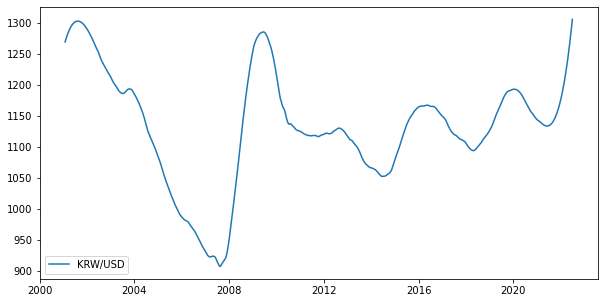

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(m_data,label='KRW/USD')
plt.legend()

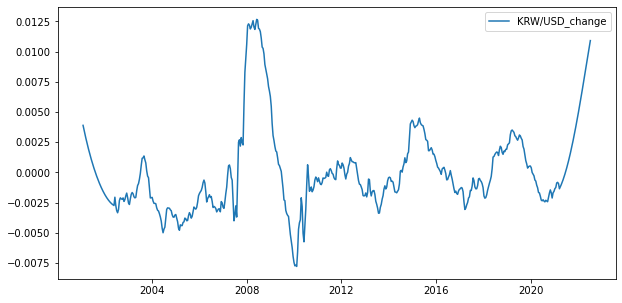

In [ ]:
#변화율 그림
plt.figure(figsize=(10,5))
plt.plot(m_data2,label='KRW/USD_change')
plt.legend()

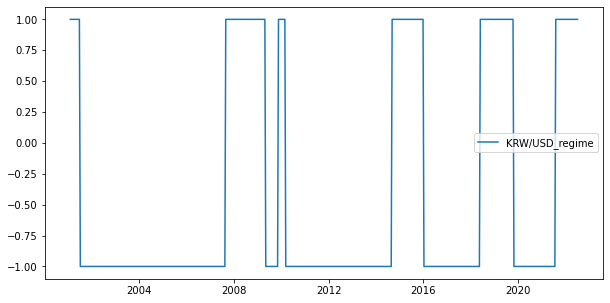

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(regime_data,label='KRW/USD_regime')
plt.legend()

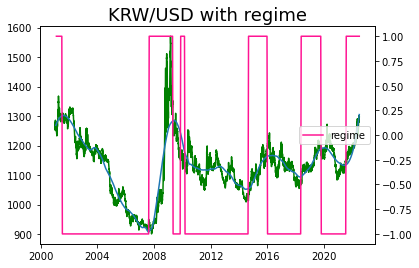

<Figure size 2160x1440 with 0 Axes>

In [ ]:

fig, ax1 = plt.subplots()
ax1.set_title('KRW/USD with regime', fontsize=18)
ax1.plot(input_data, color='green',label='data')
ax1.plot(m_data)


ax2 = ax1.twinx()
ax2.plot(regime_data, color='deeppink',label='regime')

plt.legend()
#ax2.plot(predict)
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper left')
plt.figure(figsize=(30, 20))
plt.show()

## 다음과 같이 csv파일로 저장하거나  여러 변수들을 데이터 프레임화 시켜서 저장할 수 있습니다.
## 예시로는 각자 저장하여 sector를 찾을때 따로 열어주어 데이터프레임을 합쳤습니다.
## 원달러_이주간.csv파일처럼 인플레,구리등을 추가해보았습니다.
## 투자자가 원하는 다양한 국면을 자동으로 분석해주며 이를 섹터까지 분석해줄 예정입니다

In [ ]:


regime_data.to_csv('원달러_이주간_sav.csv')

## 추가적으로 위의 자료는 2000년도 초반부터 현재까지 마르코프국면모델을 실시한 경우이며, 인샘플 아웃샘플을 나누고 싶으면, bactesting 
## 함수를 적용시켜서 이후의 값들을 in-sample데이터로 하나씩 예측해갑니다. 다음의 코드는 2015년 01월 02일부터 하나씩데이터를 늘려가며 예측을 시도한 경우입니다.
## freq를 2주 금요일마다 나타나게끔 하였으므로 날짜를 맞게 설정해야합니다

In [ ]:

predict=a.backtesting(data,'2015-01-02',2)
#predict.to_csv('원달러_2주간_예측.csv')

2015-01-02 00:00:00
d 2015-01-02 00:00:00
                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  311
Model:               MarkovRegression   Log Likelihood                1313.028
Date:                Sat, 13 Aug 2022   AIC                          -2614.056
Time:                        05:26:37   BIC                          -2591.618
Sample:                    02-07-2003   HQIC                         -2605.087
                         - 12-26-2014                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -4.247      0.000      -0.001      -0.000
sigma2    

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  314
Model:               MarkovRegression   Log Likelihood                1375.164
Date:                Sat, 13 Aug 2022   AIC                          -2738.329
Time:                        05:26:40   BIC                          -2715.832
Sample:                    02-07-2003   HQIC                         -2729.339
                         - 02-06-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.000     -9.083      0.000      -0.003      -0.002
sigma2      7.333e-06   8.61e-07      8.517      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  318
Model:               MarkovRegression   Log Likelihood                1284.166
Date:                Sat, 13 Aug 2022   AIC                          -2556.331
Time:                        05:26:45   BIC                          -2533.759
Sample:                    02-07-2003   HQIC                         -2547.316
                         - 04-03-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.204      0.228      -0.001       0.000
sigma2      1.364e-06   3.09e-07      4.418      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  322
Model:               MarkovRegression   Log Likelihood                1298.969
Date:                Sat, 13 Aug 2022   AIC                          -2585.938
Time:                        05:26:48   BIC                          -2563.290
Sample:                    02-07-2003   HQIC                         -2576.896
                         - 05-29-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.864      0.062      -0.001    1.41e-05
sigma2      1.208e-06   2.87e-07      4.207      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  326
Model:               MarkovRegression   Log Likelihood                1323.278
Date:                Sat, 13 Aug 2022   AIC                          -2634.557
Time:                        05:26:52   BIC                          -2611.835
Sample:                    02-07-2003   HQIC                         -2625.490
                         - 07-24-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -3.191      0.001      -0.001      -0.000
sigma2      1.148e-06   2.11e-07      5.444      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  330
Model:               MarkovRegression   Log Likelihood                1415.662
Date:                Sat, 13 Aug 2022   AIC                          -2819.324
Time:                        05:26:55   BIC                          -2796.529
Sample:                    02-07-2003   HQIC                         -2810.231
                         - 09-18-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.000    -10.201      0.000      -0.003      -0.002
sigma2      1.025e-05   1.12e-06      9.124      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  334
Model:               MarkovRegression   Log Likelihood                1445.616
Date:                Sat, 13 Aug 2022   AIC                          -2879.232
Time:                        05:26:59   BIC                          -2856.366
Sample:                    02-07-2003   HQIC                         -2870.115
                         - 11-13-2015                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.000    -11.366      0.000      -0.003      -0.002
sigma2      8.805e-06   9.69e-07      9.090      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  338
Model:               MarkovRegression   Log Likelihood                1465.606
Date:                Sat, 13 Aug 2022   AIC                          -2919.213
Time:                        05:27:03   BIC                          -2896.274
Sample:                    02-07-2003   HQIC                         -2910.071
                         - 01-08-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.000    -12.104      0.000      -0.003      -0.002
sigma2      8.503e-06    9.3e-07      9.143      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  342
Model:               MarkovRegression   Log Likelihood                1386.151
Date:                Sat, 13 Aug 2022   AIC                          -2760.302
Time:                        05:27:06   BIC                          -2737.293
Sample:                    02-07-2003   HQIC                         -2751.136
                         - 03-04-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.000     -3.750      0.000      -0.001      -0.000
sigma2       1.25e-06   2.84e-07      4.406      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  346
Model:               MarkovRegression   Log Likelihood                1510.991
Date:                Sat, 13 Aug 2022   AIC                          -3009.981
Time:                        05:27:10   BIC                          -2986.903
Sample:                    02-07-2003   HQIC                         -3000.791
                         - 04-29-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.000    -11.743      0.000      -0.003      -0.002
sigma2      7.359e-06    8.1e-07      9.090      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  350
Model:               MarkovRegression   Log Likelihood                1521.882
Date:                Sat, 13 Aug 2022   AIC                          -3031.765
Time:                        05:27:14   BIC                          -3008.617
Sample:                    02-07-2003   HQIC                         -3022.551
                         - 06-24-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.000    -11.397      0.000      -0.003      -0.002
sigma2      7.899e-06   8.69e-07      9.087      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  354
Model:               MarkovRegression   Log Likelihood                1538.280
Date:                Sat, 13 Aug 2022   AIC                          -3064.560
Time:                        05:27:18   BIC                          -3041.344
Sample:                    02-07-2003   HQIC                         -3055.323
                         - 08-19-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.000    -11.629      0.000      -0.003      -0.002
sigma2      7.645e-06   8.41e-07      9.087      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  358
Model:               MarkovRegression   Log Likelihood                1569.628
Date:                Sat, 13 Aug 2022   AIC                          -3127.255
Time:                        05:27:22   BIC                          -3103.972
Sample:                    02-07-2003   HQIC                         -3117.996
                         - 10-14-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.000    -11.876      0.000      -0.003      -0.002
sigma2      7.044e-06   7.72e-07      9.125      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  362
Model:               MarkovRegression   Log Likelihood                1589.436
Date:                Sat, 13 Aug 2022   AIC                          -3166.872
Time:                        05:27:25   BIC                          -3143.522
Sample:                    02-07-2003   HQIC                         -3157.589
                         - 12-09-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -11.454      0.000      -0.003      -0.002
sigma2      6.947e-06   7.53e-07      9.220      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  366
Model:               MarkovRegression   Log Likelihood                1604.978
Date:                Sat, 13 Aug 2022   AIC                          -3197.957
Time:                        05:27:30   BIC                          -3174.541
Sample:                    02-07-2003   HQIC                         -3188.652
                         - 02-03-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -11.164      0.000      -0.003      -0.002
sigma2      7.084e-06   7.69e-07      9.210      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  370
Model:               MarkovRegression   Log Likelihood                1621.494
Date:                Sat, 13 Aug 2022   AIC                          -3230.988
Time:                        05:27:34   BIC                          -3207.507
Sample:                    02-07-2003   HQIC                         -3221.661
                         - 03-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -11.137      0.000      -0.003      -0.002
sigma2      7.098e-06   7.73e-07      9.183      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  374
Model:               MarkovRegression   Log Likelihood                1632.626
Date:                Sat, 13 Aug 2022   AIC                          -3253.252
Time:                        05:27:38   BIC                          -3229.707
Sample:                    02-07-2003   HQIC                         -3243.904
                         - 05-26-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.000    -11.280      0.000      -0.003      -0.002
sigma2      7.013e-06   7.67e-07      9.140      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  378
Model:               MarkovRegression   Log Likelihood                1553.071
Date:                Sat, 13 Aug 2022   AIC                          -3094.143
Time:                        05:27:42   BIC                          -3070.533
Sample:                    02-07-2003   HQIC                         -3084.772
                         - 07-21-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -3.063      0.002      -0.001      -0.000
sigma2      1.384e-06   2.93e-07      4.729      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  382
Model:               MarkovRegression   Log Likelihood                1569.414
Date:                Sat, 13 Aug 2022   AIC                          -3126.828
Time:                        05:27:45   BIC                          -3103.156
Sample:                    02-07-2003   HQIC                         -3117.437
                         - 09-15-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -3.522      0.000      -0.001      -0.000
sigma2      1.325e-06   2.79e-07      4.748      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  386
Model:               MarkovRegression   Log Likelihood                1596.859
Date:                Sat, 13 Aug 2022   AIC                          -3181.719
Time:                        05:27:49   BIC                          -3157.984
Sample:                    02-07-2003   HQIC                         -3172.306
                         - 11-10-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -2.900      0.004      -0.001      -0.000
sigma2      1.334e-06   2.72e-07      4.908      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  390
Model:               MarkovRegression   Log Likelihood                1704.215
Date:                Sat, 13 Aug 2022   AIC                          -3396.429
Time:                        05:27:53   BIC                          -3372.633
Sample:                    02-07-2003   HQIC                         -3386.996
                         - 01-05-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -11.451      0.000      -0.003      -0.002
sigma2      6.866e-06   7.25e-07      9.477      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  394
Model:               MarkovRegression   Log Likelihood                1720.961
Date:                Sat, 13 Aug 2022   AIC                          -3429.923
Time:                        05:27:58   BIC                          -3406.065
Sample:                    02-07-2003   HQIC                         -3420.469
                         - 03-02-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -11.449      0.000      -0.003      -0.002
sigma2      6.815e-06   7.17e-07      9.503      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  398
Model:               MarkovRegression   Log Likelihood                1652.386
Date:                Sat, 13 Aug 2022   AIC                          -3292.772
Time:                        05:28:02   BIC                          -3268.854
Sample:                    02-07-2003   HQIC                         -3283.298
                         - 04-27-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -3.244      0.001      -0.001      -0.000
sigma2      1.447e-06   2.79e-07      5.188      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  402
Model:               MarkovRegression   Log Likelihood                1682.432
Date:                Sat, 13 Aug 2022   AIC                          -3352.864
Time:                        05:28:06   BIC                          -3328.885
Sample:                    02-07-2003   HQIC                         -3343.370
                         - 06-22-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      3.450      0.001       0.000       0.001
sigma2      2.505e-06   3.72e-07      6.733      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  405
Model:               MarkovRegression   Log Likelihood                1701.601
Date:                Sat, 13 Aug 2022   AIC                          -3391.202
Time:                        05:28:14   BIC                          -3367.179
Sample:                    02-07-2003   HQIC                         -3381.693
                         - 08-03-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.725e-05      0.000     -0.217      0.828      -0.000       0.000
sigma2      1.274e-06   2.42e-07      5.267      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  408
Model:               MarkovRegression   Log Likelihood                1711.186
Date:                Sat, 13 Aug 2022   AIC                          -3410.373
Time:                        05:28:24   BIC                          -3386.305
Sample:                    02-07-2003   HQIC                         -3400.849
                         - 09-14-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -3.608      0.000      -0.001      -0.000
sigma2      1.369e-06   2.32e-07      5.893      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  412
Model:               MarkovRegression   Log Likelihood                1708.632
Date:                Sat, 13 Aug 2022   AIC                          -3405.263
Time:                        05:28:27   BIC                          -3381.137
Sample:                    02-07-2003   HQIC                         -3395.720
                         - 11-09-2018                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -2.329      0.020      -0.001   -5.67e-05
sigma2      1.529e-06   2.74e-07      5.576      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  416
Model:               MarkovRegression   Log Likelihood                1724.578
Date:                Sat, 13 Aug 2022   AIC                          -3437.156
Time:                        05:28:31   BIC                          -3412.972
Sample:                    02-07-2003   HQIC                         -3427.593
                         - 01-04-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -2.219      0.027      -0.001    -3.7e-05
sigma2      1.447e-06   2.66e-07      5.447      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  420
Model:               MarkovRegression   Log Likelihood                1747.919
Date:                Sat, 13 Aug 2022   AIC                          -3483.839
Time:                        05:28:35   BIC                          -3459.597
Sample:                    02-07-2003   HQIC                         -3474.257
                         - 03-01-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -2.996      0.003      -0.001      -0.000
sigma2      1.398e-06   2.62e-07      5.342      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  424
Model:               MarkovRegression   Log Likelihood                1795.224
Date:                Sat, 13 Aug 2022   AIC                          -3578.448
Time:                        05:28:39   BIC                          -3554.150
Sample:                    02-07-2003   HQIC                         -3568.848
                         - 04-26-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.000     -5.500      0.000      -0.001      -0.000
sigma2      1.414e-06   2.53e-07      5.586      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  428
Model:               MarkovRegression   Log Likelihood                1820.546
Date:                Sat, 13 Aug 2022   AIC                          -3629.092
Time:                        05:28:42   BIC                          -3604.738
Sample:                    02-07-2003   HQIC                         -3619.474
                         - 06-21-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.000     -4.914      0.000      -0.001      -0.000
sigma2      1.299e-06   2.55e-07      5.089      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  432
Model:               MarkovRegression   Log Likelihood                1837.726
Date:                Sat, 13 Aug 2022   AIC                          -3663.452
Time:                        05:28:46   BIC                          -3639.041
Sample:                    02-07-2003   HQIC                         -3653.814
                         - 08-16-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.000     -5.004      0.000      -0.001      -0.001
sigma2      1.405e-06   3.18e-07      4.424      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  436
Model:               MarkovRegression   Log Likelihood                1925.192
Date:                Sat, 13 Aug 2022   AIC                          -3838.385
Time:                        05:28:51   BIC                          -3813.919
Sample:                    02-07-2003   HQIC                         -3828.729
                         - 10-11-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -13.162      0.000      -0.003      -0.002
sigma2      6.063e-06   5.72e-07     10.602      0.0

d 2019-12-13 00:00:00
                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  440
Model:               MarkovRegression   Log Likelihood                1945.473
Date:                Sat, 13 Aug 2022   AIC                          -3878.947
Time:                        05:28:55   BIC                          -3854.426
Sample:                    02-07-2003   HQIC                         -3869.273
                         - 12-06-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -13.492      0.000      -0.003      -0.002
sigma2      5.949e-06   5.58e-

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  444
Model:               MarkovRegression   Log Likelihood                1893.678
Date:                Sat, 13 Aug 2022   AIC                          -3775.356
Time:                        05:28:59   BIC                          -3750.781
Sample:                    02-07-2003   HQIC                         -3765.665
                         - 01-31-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.000     -6.529      0.000      -0.002      -0.001
sigma2      2.025e-06   9.71e-07      2.085      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  448
Model:               MarkovRegression   Log Likelihood                1914.304
Date:                Sat, 13 Aug 2022   AIC                          -3816.607
Time:                        05:29:03   BIC                          -3791.978
Sample:                    02-07-2003   HQIC                         -3806.898
                         - 03-27-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.000     -7.906      0.000      -0.002      -0.001
sigma2      2.014e-06   4.86e-07      4.140      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  452
Model:               MarkovRegression   Log Likelihood                2003.472
Date:                Sat, 13 Aug 2022   AIC                          -3994.944
Time:                        05:29:08   BIC                          -3970.262
Sample:                    02-07-2003   HQIC                         -3985.217
                         - 05-22-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.000    -14.264      0.000      -0.003      -0.002
sigma2      5.776e-06   5.33e-07     10.828      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  456
Model:               MarkovRegression   Log Likelihood                2017.868
Date:                Sat, 13 Aug 2022   AIC                          -4023.737
Time:                        05:29:12   BIC                          -3999.002
Sample:                    02-07-2003   HQIC                         -4013.993
                         - 07-17-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.000    -14.523      0.000      -0.003      -0.002
sigma2      5.925e-06   5.45e-07     10.864      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  460
Model:               MarkovRegression   Log Likelihood                2046.419
Date:                Sat, 13 Aug 2022   AIC                          -4080.838
Time:                        05:29:16   BIC                          -4056.051
Sample:                    02-07-2003   HQIC                         -4071.078
                         - 09-11-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -14.659      0.000      -0.003      -0.002
sigma2      5.511e-06   5.03e-07     10.966      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  464
Model:               MarkovRegression   Log Likelihood                2050.745
Date:                Sat, 13 Aug 2022   AIC                          -4089.491
Time:                        05:29:20   BIC                          -4064.651
Sample:                    02-07-2003   HQIC                         -4079.713
                         - 11-06-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -13.039      0.000      -0.003      -0.002
sigma2      5.966e-06   5.44e-07     10.971      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  468
Model:               MarkovRegression   Log Likelihood                2066.021
Date:                Sat, 13 Aug 2022   AIC                          -4120.042
Time:                        05:29:25   BIC                          -4095.151
Sample:                    02-07-2003   HQIC                         -4110.247
                         - 01-01-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -13.203      0.000      -0.003      -0.002
sigma2      6.116e-06   5.62e-07     10.892      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  472
Model:               MarkovRegression   Log Likelihood                2057.340
Date:                Sat, 13 Aug 2022   AIC                          -4102.680
Time:                        05:29:29   BIC                          -4077.738
Sample:                    02-07-2003   HQIC                         -4092.869
                         - 02-26-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -13.280      0.000      -0.003      -0.002
sigma2      6.146e-06   5.69e-07     10.807      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  476
Model:               MarkovRegression   Log Likelihood                2030.203
Date:                Sat, 13 Aug 2022   AIC                          -4048.406
Time:                        05:29:33   BIC                          -4023.413
Sample:                    02-07-2003   HQIC                         -4038.578
                         - 04-23-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -13.219      0.000      -0.003      -0.002
sigma2      6.119e-06   5.72e-07     10.697      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  480
Model:               MarkovRegression   Log Likelihood                2021.022
Date:                Sat, 13 Aug 2022   AIC                          -4030.045
Time:                        05:29:37   BIC                          -4005.002
Sample:                    02-07-2003   HQIC                         -4020.201
                         - 06-18-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.000    -12.838      0.000      -0.003      -0.002
sigma2      6.154e-06   5.81e-07     10.591      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  484
Model:               MarkovRegression   Log Likelihood                2037.514
Date:                Sat, 13 Aug 2022   AIC                          -4063.028
Time:                        05:29:41   BIC                          -4037.936
Sample:                    02-07-2003   HQIC                         -4053.169
                         - 08-13-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -11.998      0.000      -0.003      -0.002
sigma2      6.378e-06   6.09e-07     10.470      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  488
Model:               MarkovRegression   Log Likelihood                2090.199
Date:                Sat, 13 Aug 2022   AIC                          -4168.399
Time:                        05:29:45   BIC                          -4143.257
Sample:                    02-07-2003   HQIC                         -4158.523
                         - 10-08-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -12.755      0.000      -0.003      -0.002
sigma2      6.267e-06   5.92e-07     10.586      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  492
Model:               MarkovRegression   Log Likelihood                2140.915
Date:                Sat, 13 Aug 2022   AIC                          -4269.831
Time:                        05:29:49   BIC                          -4244.640
Sample:                    02-07-2003   HQIC                         -4259.939
                         - 12-03-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -12.486      0.000      -0.003      -0.002
sigma2      6.348e-06   6.03e-07     10.533      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  496
Model:               MarkovRegression   Log Likelihood                2168.415
Date:                Sat, 13 Aug 2022   AIC                          -4324.831
Time:                        05:29:54   BIC                          -4299.591
Sample:                    02-07-2003   HQIC                         -4314.923
                         - 01-28-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -12.732      0.000      -0.003      -0.002
sigma2      6.316e-06   5.94e-07     10.639      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  500
Model:               MarkovRegression   Log Likelihood                2181.335
Date:                Sat, 13 Aug 2022   AIC                          -4350.670
Time:                        05:29:57   BIC                          -4325.382
Sample:                    02-07-2003   HQIC                         -4340.747
                         - 03-25-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -12.925      0.000      -0.003      -0.002
sigma2      6.274e-06   5.86e-07     10.697      0.0

                        Markov Switching Model Results                        
Dep. Variable:                      0   No. Observations:                  504
Model:               MarkovRegression   Log Likelihood                2196.180
Date:                Sat, 13 Aug 2022   AIC                          -4380.360
Time:                        05:30:02   BIC                          -4355.024
Sample:                    02-07-2003   HQIC                         -4370.422
                         - 05-20-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -12.798      0.000      -0.003      -0.002
sigma2      6.283e-06   5.89e-07     10.663      0.0


## 위와같이 변수에 따라 국면을 따로 저장한 파일들을 전부 열어 줍니다.
## 굳이 저장할 필요없이 국면데이터들을 데이터프레임으로 결합하여 사용하셔도 무방합니다.
## 예시파일에는 인플레이션(BEI)지수, 구리,원달러,위안화를 사용하였으며, 사용자가 원하는 국면에 따라 자유로이 사용할 수 있게끔 하였습니다.

In [ ]:
file_list=['원자재',"원달러"]
for index,i in enumerate(file_list):
    data = pd.read_csv(i+'_이주간_sav'+'.csv', index_col = 0)
    data.index = pd.to_datetime(data.index)
    data.columns = [i]
    data=data.replace(0,1)
    # 섹터지수가 2010년부터 존재하므로 데이터는 2010년 이전 값은 잘라줍니다.
    year='2010'
    if index == 0 :
        last_data=data.copy()
    else:
        last_data = pd.merge(last_data.loc[year:],data.loc[year:], left_index= True, right_index= True)

## 날짜가 전부 동일하게끔 데이터프레임을 맞춰주었습니다.

In [ ]:
all_regime_data=last_data.copy()

In [ ]:
all_regime_data

,원자재,원달러
2010-01-08,1,1
2010-01-22,1,-1
2010-02-05,1,-1
2010-02-19,1,-1
2010-03-05,1,-1
...,...,...
2022-04-29,-1,1
2022-05-13,-1,1
2022-05-27,-1,1
2022-06-10,-1,1


## 다음은 KRX 홈페이지에서 직접 섹터별 지수데이터를 가져와 데이터프레임화 시킨 파일입니다. 영업일 기준으로 변화율로 바꿔줍니다.

## 해당파일에서 모든 기준은 금요일 종가로 기준을 맞추어줬습니다.
## 주의 기간은 바꿀 수 있으나 (ex. 1주 / 2주 /3주) 요일을 바꿀 순 없게하였습니다.

In [ ]:
index_total = pd.read_csv('0715 섹터 종가.csv', index_col=0, encoding='cp949')
index_total.index = pd.to_datetime((index_total.index))
sectors = index_total.iloc[:,:-1]
sectors.columns=[i.replace('종가','').replace(" ",'') for i in list(sectors.columns)]
sector_origin=sectors.copy()

In [ ]:
#일별 변화량으로 바꿔줍니다.
sectors=sectors.resample(rule='B').last().ffill().pct_change().dropna()

## 충격반응함수와 상관계수로 섹터의 종류를 줄이는 코드입니다.

## 우선 correalation으로 0.7이상인 섹터들은 둘 중에 한개를 제거해주는 방향으로 진행하였습니다. 이는 아웃퍼폼섹터를 추출하는데 중복으로 섹터가 잡히는 것을 방지하기 위함입니다.

In [ ]:
sec_cor=sectors.corr()

In [ ]:
all_sector=list(sec_cor.columns)

In [ ]:
search_sector_list=[]
for i in sec_cor:
    tmt_sec_data=sec_cor.loc[i]
    not_sector=tmt_sec_data[(tmt_sec_data>0.7) & (tmt_sec_data!=1) ]
    #print(not_sector)
    for ii in not_sector.index:
        if (ii in all_sector) and (ii not in search_sector_list):
            print(ii +'가 제거됩니다.')
            all_sector.remove(ii)
            search_sector_list.append(i)

sectors=sectors.loc[:,all_sector]

KRX_보험가 제거됩니다.
KRX_증권가 제거됩니다.
KRX_은행가 제거됩니다.
코스피_대형주가 제거됩니다.
코스피_보험가 제거됩니다.
코스피_증권가 제거됩니다.
코스피_금융업가 제거됩니다.
코스피_200금융가 제거됩니다.
코스피200초대형제외지수가 제거됩니다.
코스피200비중상한20%가 제거됩니다.
코스피_200비중상한25%가 제거됩니다.
코스피_200비중상한30%가 제거됩니다.
KRX_정보기술가 제거됩니다.
KRX_반도체가 제거됩니다.
코스피_제조업가 제거됩니다.
코스피_전기전자가 제거됩니다.
코스피_200정보기술가 제거됩니다.
코스피200TOP10가 제거됩니다.
kosdaq_우량기업가 제거됩니다.
kosdaq_반도체가 제거됩니다.
kosdaq_IT_HW가 제거됩니다.
kosdaq_IT가 제거됩니다.
코스피_전기가스업가 제거됩니다.
kosdaq_IT부품가 제거됩니다.
KRX_300커뮤니케이션서비스가 제거됩니다.
코스피_서비스업가 제거됩니다.
코스피200커뮤니케이션서비스가 제거됩니다.
kosdaq_IT_SW가 제거됩니다.
KRX300필수소비재가 제거됩니다.
코스피_화학가 제거됩니다.
코스피_음식료품가 제거됩니다.
코스피_200생활소비재가 제거됩니다.
KRX_300산업재가 제거됩니다.
KRX_300자유소비재가 제거됩니다.
코스피_중형주가 제거됩니다.
코스피_유통업가 제거됩니다.
코스피200제외코스피지수가 제거됩니다.
코스피_200중소형주가 제거됩니다.
코스피_소형주가 제거됩니다.
kosdaq_자유소비재가 제거됩니다.
코스피_운수창고업가 제거됩니다.
코스피_200산업재가 제거됩니다.
KRX_건설가 제거됩니다.
코스피_기계가 제거됩니다.
코스피_200중공업가 제거됩니다.
코스피_200건설가 제거됩니다.
코스피_건설업가 제거됩니다.
코스피_비금속광물가 제거됩니다.
kosdaq_금속가 제거됩니다.
코스피_통신업가 제거됩니다.
KRX_300소재가 제거됩니다.
코스피_철강금속가 제거됩니다.
코스피_200철강소재가 제거됩니다.
코스피_200에너지화학가 제거됩니다.
KRX_

## 상관계수를 이용해서 섹터 수를 줄인 결과입니다.

<AxesSubplot:>

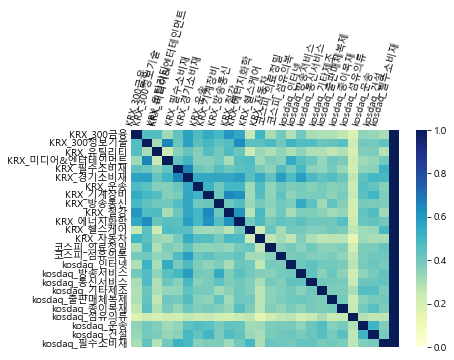

In [ ]:
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap

plot_weight_heatmap(sectors.corr(),
                    add_sum_column=True,
                    time_format=None,
                    time_skips=1)

In [ ]:
## 다음은 거시적 변수에 충격을 주었을때 유의미하게 반응한 섹터들만 추출하기 위해서 충격반응항수를 실행한 결과입니다.



## 다음은 CRB_data로 충격반응 함수를 진행하여 원자재 데이터 충격이 일정량 이상으로 가해진 섹터데이터만 추출해냈습니다.

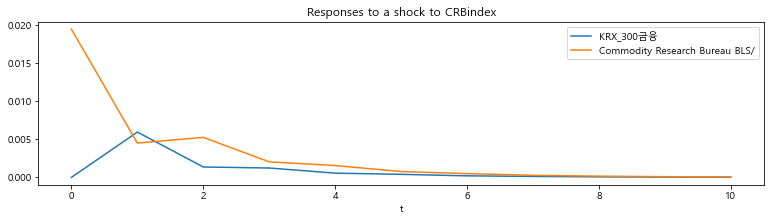

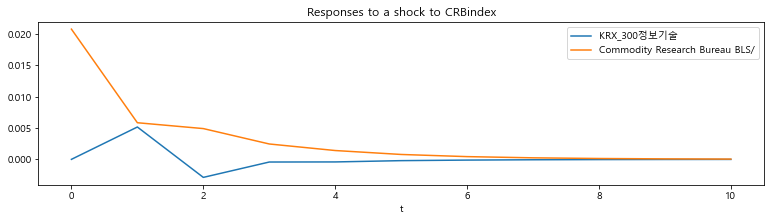

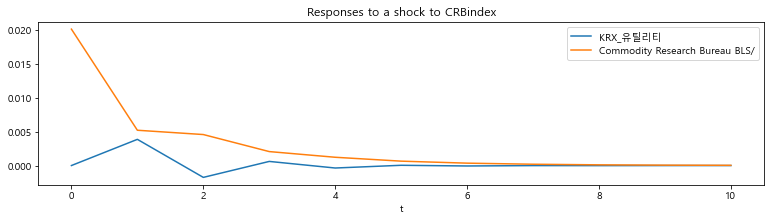

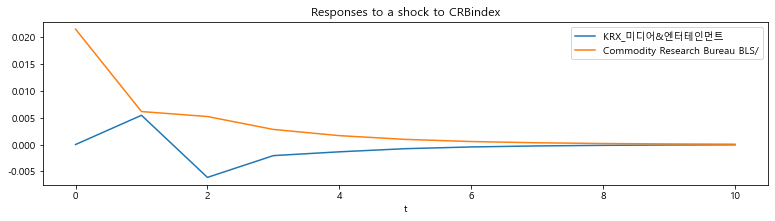

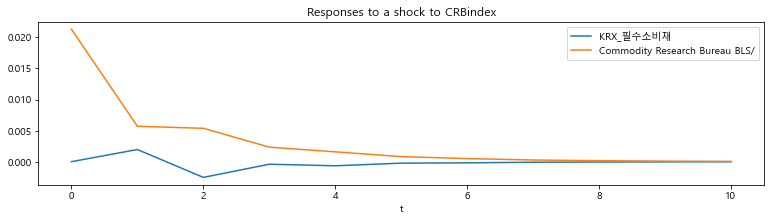

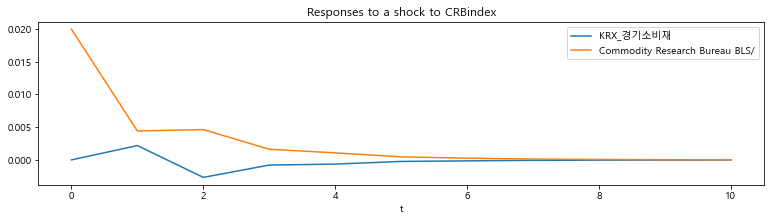

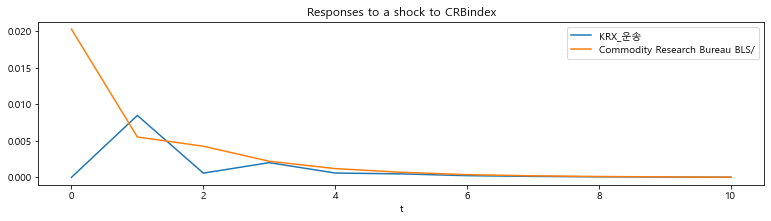

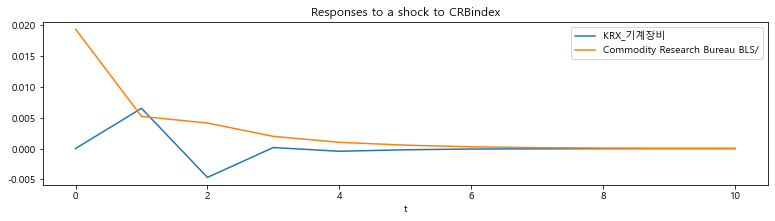

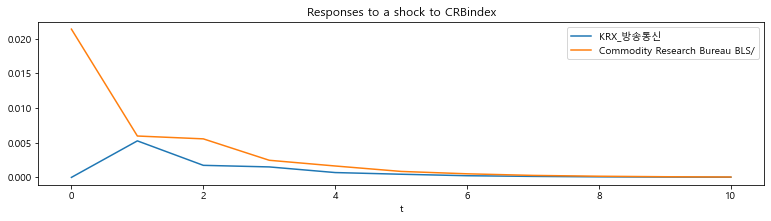

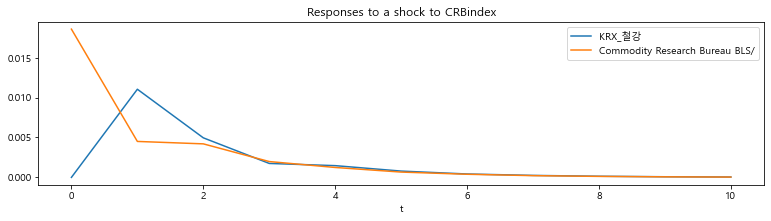

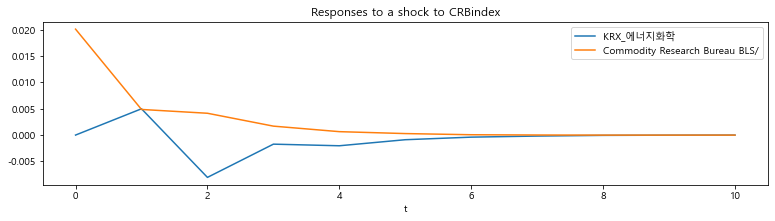

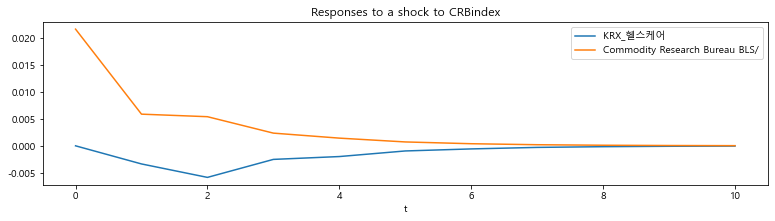

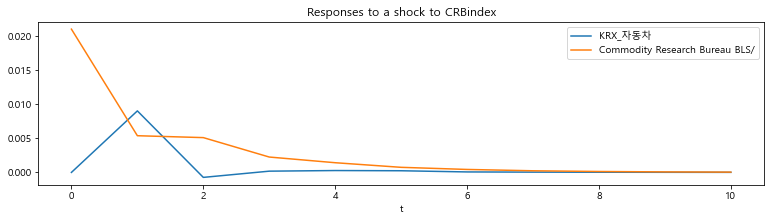

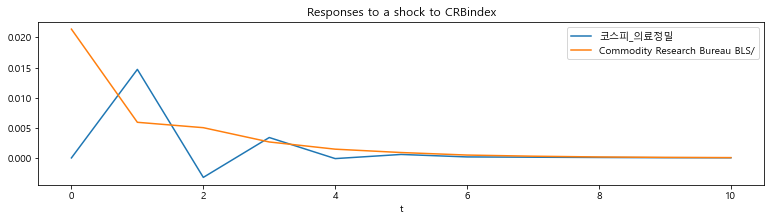

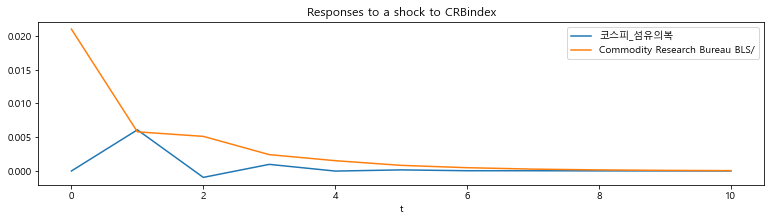

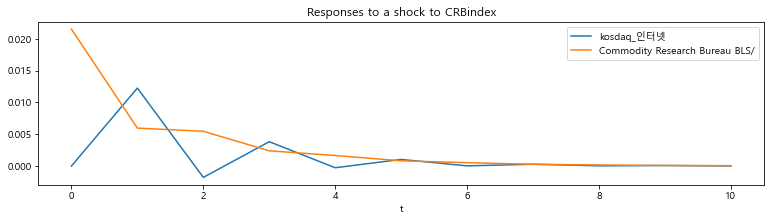

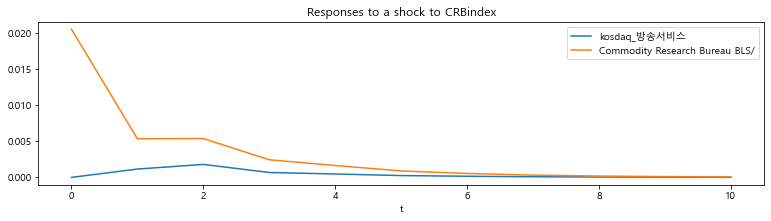

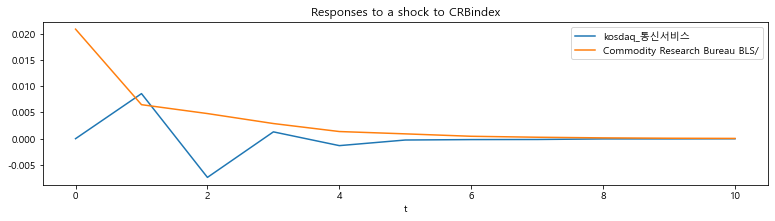

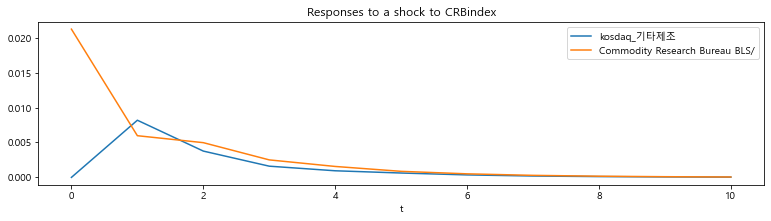

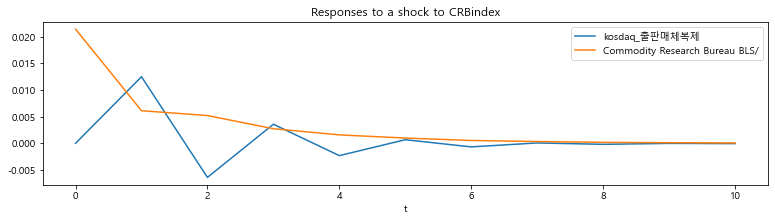

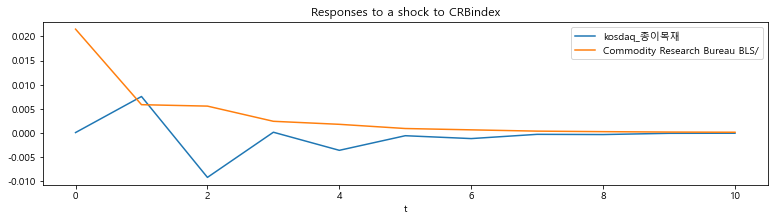

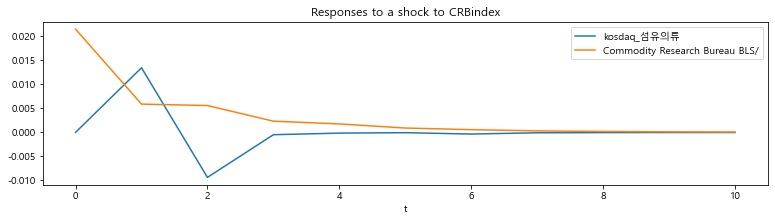

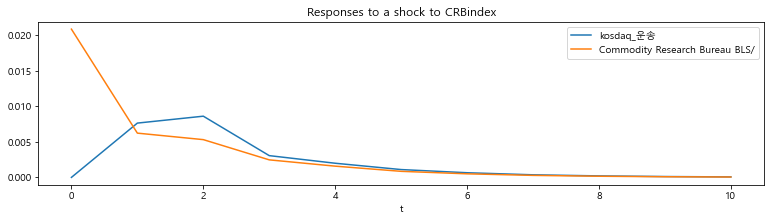

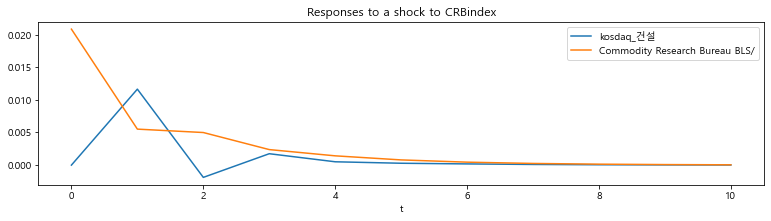

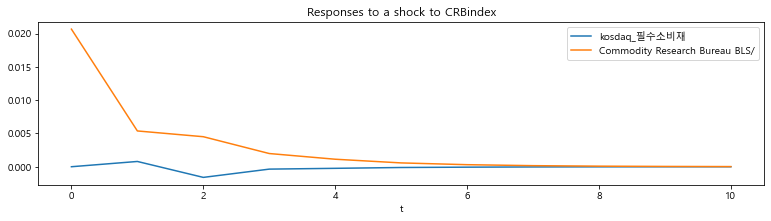

In [ ]:
import statsmodels.api as sm

impulse_list=[]
for i in sectors.columns:
    impulse_data=pd.concat([sector_origin.loc[:,i],CRB_data],axis=1).dropna()

    impulse_data=impulse_data.asfreq('4w-fri').pct_change().dropna()
    
    mod = sm.tsa.VARMAX(impulse_data, order=(2,0), trend='n')
    res = mod.fit(maxiter=1000, disp=False)
    #print(res.summary())

    ax = res.impulse_responses(10, orthogonalized=True, impulse=[0, 1]).plot(figsize=(13,3))
    ax.set(xlabel='t', title='Responses to a shock to CRBindex');
    impluse_value=res.impulse_responses(10, orthogonalized=True, impulse=[0, 1]).loc[:,i]
    # 기준 값은 거시적변수가 자기자신에게 가해진 충격의 1시점 이후 중에서 max값을 가져옵니다.
    max_value=max(res.impulse_responses(10, orthogonalized=True, impulse=[0, 1]).iloc[1:,1])
    
    for value in impluse_value:
        if abs(value) >max_value  :
            impulse_list.append(i)
    
    

In [ ]:
impulse_list

['KRX_300금융',
 'KRX_운송',
 'KRX_기계장비',
 'KRX_철강',
 'KRX_철강',
 'KRX_에너지화학',
 'KRX_에너지화학',
 'KRX_자동차',
 '코스피_의료정밀',
 '코스피_섬유의복',
 'kosdaq_인터넷',
 'kosdaq_통신서비스',
 'kosdaq_통신서비스',
 'kosdaq_기타제조',
 'kosdaq_출판매체복제',
 'kosdaq_출판매체복제',
 'kosdaq_종이목재',
 'kosdaq_종이목재',
 'kosdaq_섬유의류',
 'kosdaq_섬유의류',
 'kosdaq_운송',
 'kosdaq_운송',
 'kosdaq_건설']

                              Statespace Model Results                              
Dep. Variable:     ['KRX_300금융', 'KRW/USD']   No. Observations:                  145
Model:                               VAR(2)   Log Likelihood                 590.624
Date:                      Sat, 13 Aug 2022   AIC                          -1159.249
Time:                              04:39:35   BIC                          -1126.505
Sample:                          06-10-2011   HQIC                         -1145.944
                               - 06-24-2022                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):          3.31, 68.65
Prob(Q):                        0.93, 0.99   Prob(JB):                   0.19, 0.00
Heteroskedasticity (H):         2.02, 0.40   Skew:                      -0.09, 0.92
Prob(H) (two-sided):            0.02, 0.00   Kurtosis:              

                                 Statespace Model Results                                
Dep. Variable:     ['KRX_미디어&엔터테인먼트', 'KRW/USD']   No. Observations:                  145
Model:                                    VAR(2)   Log Likelihood                 563.139
Date:                           Sat, 13 Aug 2022   AIC                          -1104.278
Time:                                   04:39:36   BIC                          -1071.534
Sample:                               06-10-2011   HQIC                         -1090.973
                                    - 06-24-2022                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):             0.03, 0.01   Jarque-Bera (JB):         67.22, 66.17
Prob(Q):                        0.86, 0.92   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.02, 0.46   Skew:                       0.65, 0.66
Prob(H) (two-sided):        

                             Statespace Model Results                            
Dep. Variable:     ['KRX_운송', 'KRW/USD']   No. Observations:                  145
Model:                            VAR(2)   Log Likelihood                 548.627
Date:                   Sat, 13 Aug 2022   AIC                          -1075.254
Time:                           04:39:38   BIC                          -1042.510
Sample:                       06-10-2011   HQIC                         -1061.949
                            - 06-24-2022                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.00, 0.03   Jarque-Bera (JB):         27.98, 14.29
Prob(Q):                        0.97, 0.86   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.49, 0.65   Skew:                       0.53, 0.45
Prob(H) (two-sided):            0.17, 0.14   Kurtosis:                   4.87, 4.25
        

                             Statespace Model Results                            
Dep. Variable:     ['KRX_철강', 'KRW/USD']   No. Observations:                  145
Model:                            VAR(2)   Log Likelihood                 552.826
Date:                   Sat, 13 Aug 2022   AIC                          -1083.651
Time:                           04:39:40   BIC                          -1050.907
Sample:                       06-10-2011   HQIC                         -1070.346
                            - 06-24-2022                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.00, 0.01   Jarque-Bera (JB):          4.37, 26.03
Prob(Q):                        1.00, 0.92   Prob(JB):                   0.11, 0.00
Heteroskedasticity (H):         1.77, 0.67   Skew:                       0.19, 0.65
Prob(H) (two-sided):            0.05, 0.17   Kurtosis:                   3.76, 4.62
        

                             Statespace Model Results                             
Dep. Variable:     ['KRX_자동차', 'KRW/USD']   No. Observations:                  145
Model:                             VAR(2)   Log Likelihood                 544.169
Date:                    Sat, 13 Aug 2022   AIC                          -1066.338
Time:                            04:39:42   BIC                          -1033.594
Sample:                        06-10-2011   HQIC                         -1053.033
                             - 06-24-2022                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.01, 0.04   Jarque-Bera (JB):         12.69, 66.25
Prob(Q):                        0.94, 0.83   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.87, 0.48   Skew:                       0.20, 0.86
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:                   4.40, 5.83


                               Statespace Model Results                              
Dep. Variable:     ['kosdaq_인터넷', 'KRW/USD']   No. Observations:                  145
Model:                                VAR(2)   Log Likelihood                 520.690
Date:                       Sat, 13 Aug 2022   AIC                          -1019.381
Time:                               04:39:43   BIC                           -986.637
Sample:                           06-10-2011   HQIC                         -1006.076
                                - 06-24-2022                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):             0.07, 0.06   Jarque-Bera (JB):         48.74, 44.77
Prob(Q):                        0.79, 0.81   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.67, 0.55   Skew:                       0.82, 0.61
Prob(H) (two-sided):            0.16, 0.04   Kurtosis:      

                               Statespace Model Results                               
Dep. Variable:     ['kosdaq_기타제조', 'KRW/USD']   No. Observations:                  145
Model:                                 VAR(2)   Log Likelihood                 532.919
Date:                        Sat, 13 Aug 2022   AIC                          -1043.839
Time:                                04:39:45   BIC                          -1011.094
Sample:                            06-10-2011   HQIC                         -1030.533
                                 - 06-24-2022                                         
Covariance Type:                          opg                                         
Ljung-Box (L1) (Q):             0.08, 0.00   Jarque-Bera (JB):         13.13, 36.71
Prob(Q):                        0.78, 0.96   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.65, 0.54   Skew:                       0.53, 0.66
Prob(H) (two-sided):            0.08, 0.03   Kurtosi

                               Statespace Model Results                               
Dep. Variable:     ['kosdaq_섬유의류', 'KRW/USD']   No. Observations:                  145
Model:                                 VAR(2)   Log Likelihood                 430.596
Date:                        Sat, 13 Aug 2022   AIC                           -839.192
Time:                                04:39:47   BIC                           -806.448
Sample:                            06-10-2011   HQIC                          -825.887
                                 - 06-24-2022                                         
Covariance Type:                          opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):       9846.33, 59.94
Prob(Q):                        0.96, 1.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.67, 0.46   Skew:                       4.44, 0.74
Prob(H) (two-sided):            0.17, 0.01   Kurtosi

                                Statespace Model Results                               
Dep. Variable:     ['kosdaq_필수소비재', 'KRW/USD']   No. Observations:                  145
Model:                                  VAR(2)   Log Likelihood                 519.201
Date:                         Sat, 13 Aug 2022   AIC                          -1016.403
Time:                                 04:39:49   BIC                           -983.659
Sample:                             06-10-2011   HQIC                         -1003.098
                                  - 06-24-2022                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):             0.04, 0.01   Jarque-Bera (JB):         18.73, 65.53
Prob(Q):                        0.85, 0.91   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.22, 0.47   Skew:                       0.72, 0.78
Prob(H) (two-sided):            0.01, 0.01  

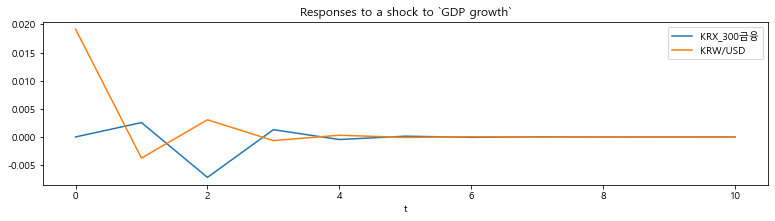

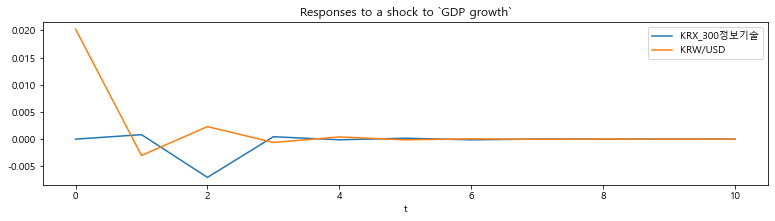

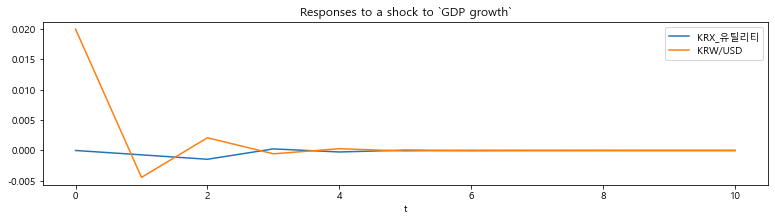

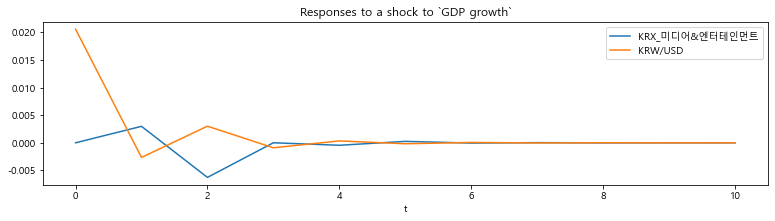

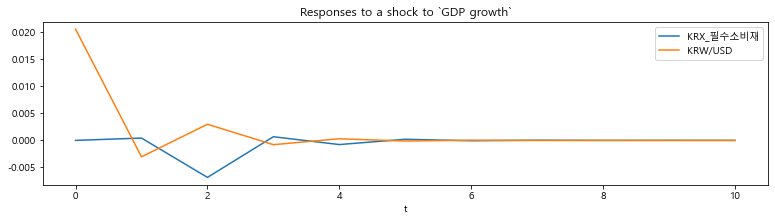

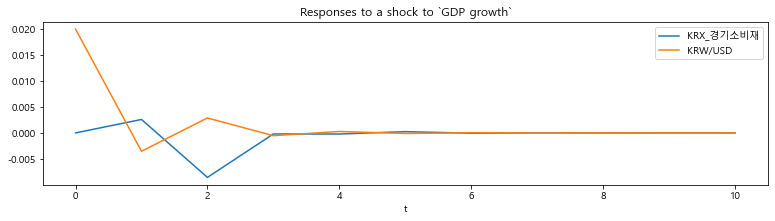

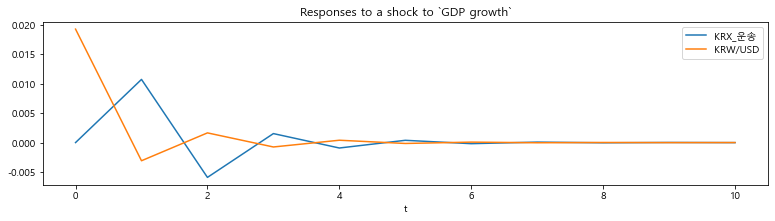

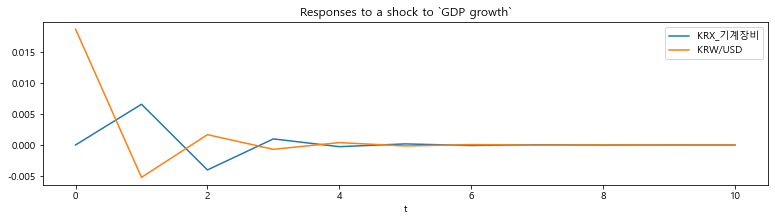

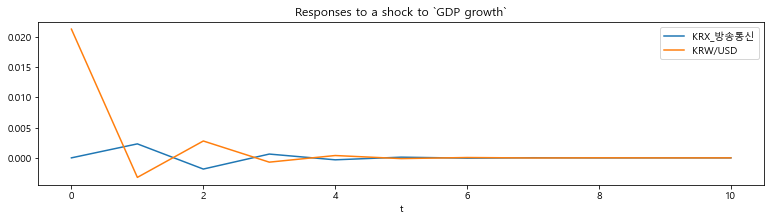

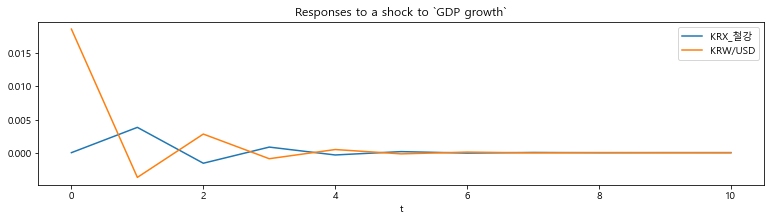

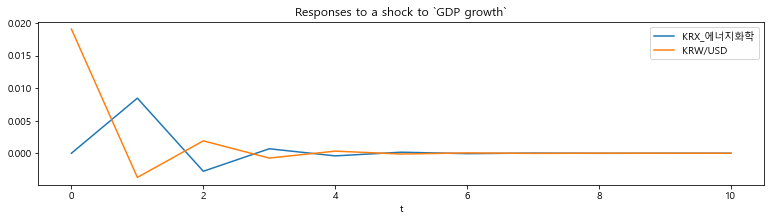

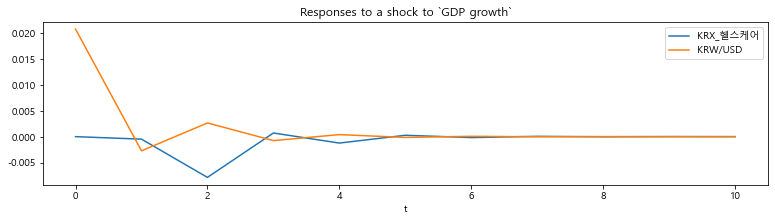

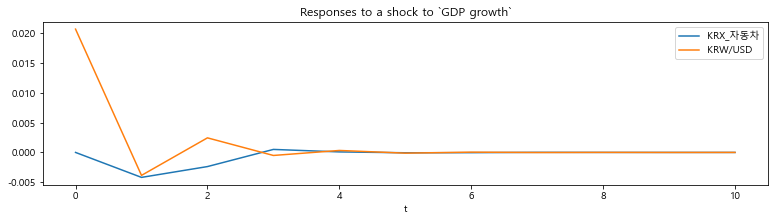

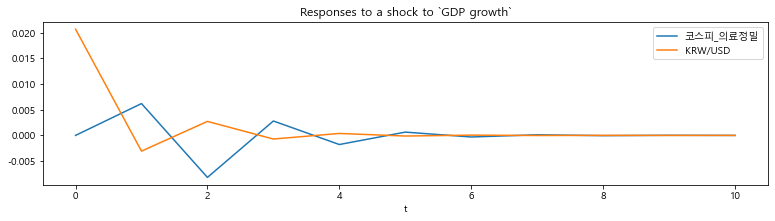

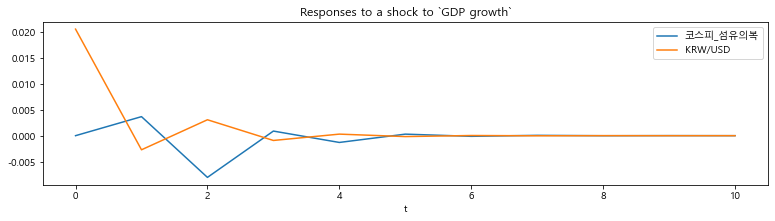

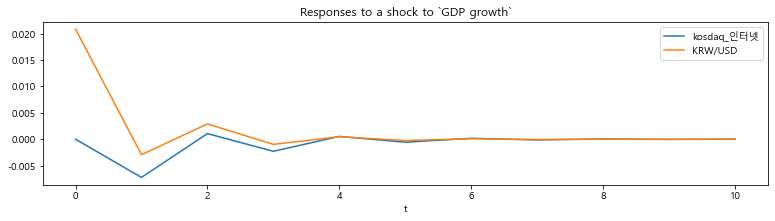

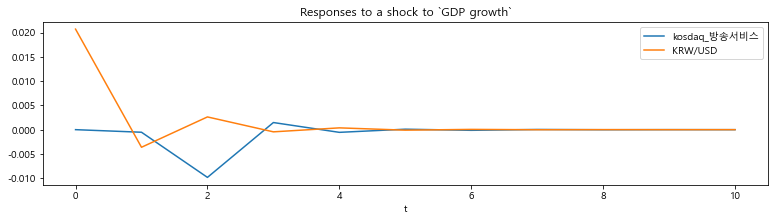

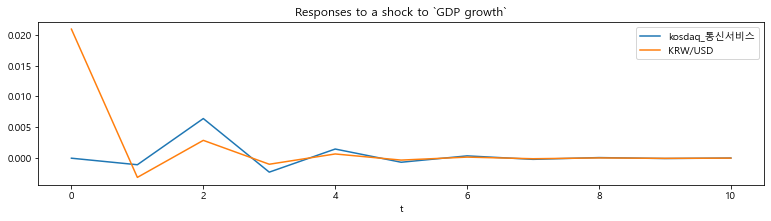

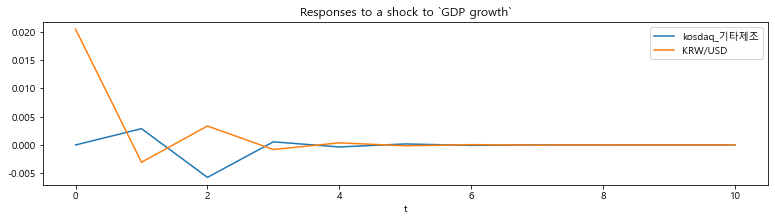

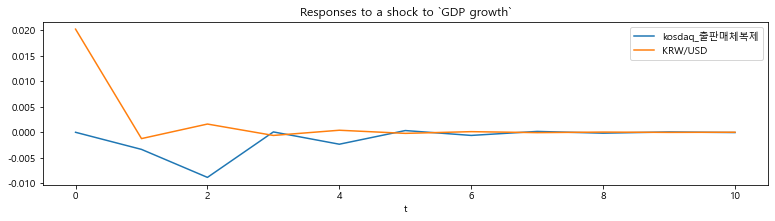

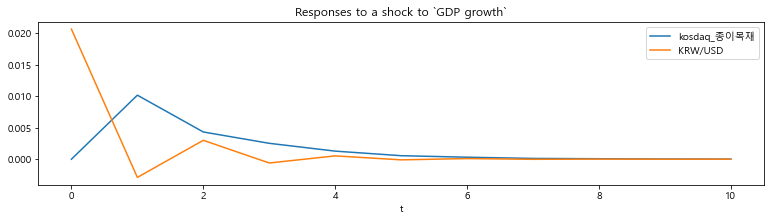

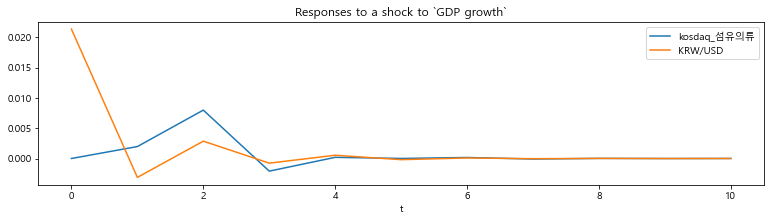

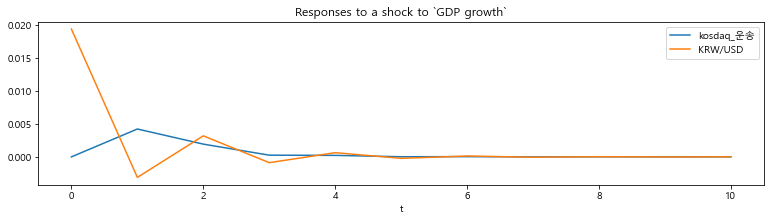

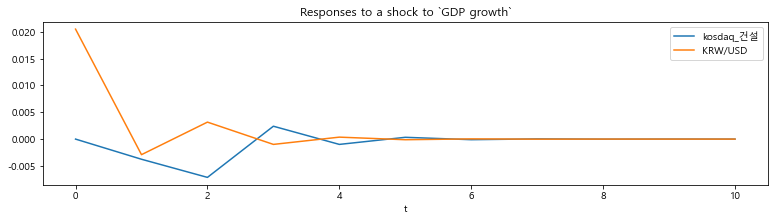

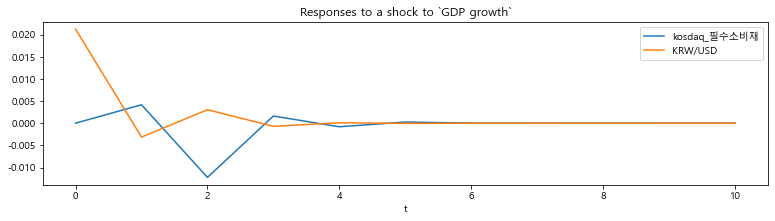

In [ ]:
# 다음은 KRW_data로 충격반응 함수를 진행하여 환율데이터 충격이 일정량 이상으로 가해진 섹터데이터만 추출해냈습니다.
impulse_list1=[]
for i in sectors.columns:
    impulse_data=pd.concat([sector_origin.loc[:,i],KRW_data],axis=1).dropna()

    impulse_data=impulse_data.asfreq('4w-fri').pct_change().dropna()
    import statsmodels.api as sm
    mod = sm.tsa.VARMAX(impulse_data, order=(2,0), trend='n')
    res = mod.fit(maxiter=1000, disp=False)
    print(res.summary())

    ax = res.impulse_responses(10, orthogonalized=True, impulse=[0, 1]).plot(figsize=(13,3))
    ax.set(xlabel='t', title='Responses to a shock to `GDP growth`');
    impluse_value=res.impulse_responses(10, orthogonalized=True, impulse=[0, 1]).loc[:,i]
    max_value=max(res.impulse_responses(10, orthogonalized=True, impulse=[0, 1]).iloc[1:,1])
    
    for value in impluse_value:
        if abs(value) >max_value:
            impulse_list1.append(i)

In [ ]:
last_impulse_list=list(set(impulse_list+impulse_list1))
sectors=sectors.loc[:,last_impulse_list]

## 최종 채택된 섹터의 종류는 다음과 같습니다.

In [ ]:

sectors.columns

Index(['코스피_섬유의복', 'kosdaq_기타제조', 'kosdaq_섬유의류', 'kosdaq_인터넷', 'KRX_300금융',
       'KRX_철강', 'KRX_헬스케어', 'KRX_기계장비', 'kosdaq_출판매체복제', 'KRX_미디어&엔터테인먼트',
       'KRX_자동차', 'kosdaq_운송', 'kosdaq_건설', 'kosdaq_종이목재', 'kosdaq_필수소비재',
       '코스피_의료정밀', 'KRX_300정보기술', 'KRX_운송', 'KRX_경기소비재', 'KRX_에너지화학',
       'KRX_필수소비재', 'kosdaq_통신서비스', 'kosdaq_방송서비스'],
      dtype='object')


## 다음 클래스는 국면 데이터프레임과, 섹터데이터프레임을 통해 국면별 아웃퍼폼하는 섹터를 찾아주는 클래스입니다.

## 사용방법은 아래의 예시 사용법을 적어두었습니다.

In [ ]:
class regime_analyze:
    def __init__(self,data,sector_data):
        print('알파찾기 시작합니다.')
        #print('알파찾기 시작합니다.')
        self.regime_sys_data=''
        self.origin_data=data
        self.sector_data=sector_data
        
        
        

        stock_list=['KS11','KQ11','KRX100']
        for index,stock in enumerate(stock_list):

            #stock_data=fdr.DataReader(stock,start)
            stock_data=fdr.DataReader(stock,'2002')
            close=stock_data.loc[:,'Close']
            if index==0:
                close_data=pd.DataFrame(close)
            else:
                close_data=pd.concat([close_data,pd.DataFrame(close)],axis=1)
            
        close_data.index=pd.to_datetime(close_data.index)
        close_data.columns=['코스피','코스닥','KRX']

    
    
        self.benchmark_data=close_data
        
        
        
        self.benchmark_data=self.benchmark_data.resample(rule='B').last().ffill().pct_change()
        self.benchmark_data=self.benchmark_data.dropna().loc[self.sector_data.index,:]
        print(len(self.sector_data.index),len(self.benchmark_data))
        

        
        
        
    #원하는 두 변수를 입력시 두개의 국면 조합에따라 총 4개의 국면이 나오게 합니다.    
    def regime_mix(self,obj1,obj2): 
        
        col=[]
        mix_regime_list=[]
        
        x=self.origin_data.loc[:,obj1]
        y=self.origin_data.loc[:,obj2]

        
        if len(x)!=len(y):
            
            print('시계열이 같지 않습니다.')
            return False
        
        
        
        
        for ii in range(len(x)):
            if x[ii] == 1 and y[ii] == 1:
                mix_regime_list.append(0)
            elif x[ii] == 1 and y[ii] == -1:
                mix_regime_list.append(1)
            elif x[ii] == -1 and y[ii] == 1:
                mix_regime_list.append(2)
            elif x[ii] ==-1 and y[ii] ==-1:
                mix_regime_list.append(3)
            else:
                print('에러')
                return False
        if len(self.regime_sys_data)!=0:
            if obj1+obj2 in self.regime_sys_data.columns:
                print('이미 있습니다.')
                return self.regime_sys_data.loc[:,obj1+obj2]
            elif obj2+obj1 in self.regime_sys_data.columns:
                print('이미 있습니다.')
                return self.regime_sys_data.loc[:,obj2+obj1]
            col=list(self.regime_sys_data.columns)
        
        
        new_data=pd.DataFrame(mix_regime_list)
        new_data.index=self.origin_data.index
        if len(col) == 0:
            new_data.columns=[obj1+obj2]
        else:
            print(col,obj1+obj2)
            #col.append()
            
            new_data.columns=[obj1+obj2]
        
        if len(self.regime_sys_data)==0:
            self.regime_sys_data=new_data
            self.regime_sys_data.index=self.origin_data.index
            new_data=pd.DataFrame(new_data)
            new_data.index=self.origin_data.index
        else:
            self.regime_sys_data=pd.concat([self.regime_sys_data,new_data],axis=1)
            
        return new_data
    
    # self. regime_sys_data에 종합 국면을 저장해줍니다.
    # 이후 put함수에 따라 원하는 종합국면을 골라주고 아웃퍼폼 섹터를 색출해냅니다.
    # 뿐만아니라 start_year을 이용해 연도를 변경해줄 수 있습니다.
    
    def put(self,sector_data,x,y,change_start_year='2003',end_year=""):
        
        if end_year =="":
        
            data=self.regime_sys_data.loc[change_start_year:,:]
            print("시작")
        else:
            data=self.regime_sys_data.loc[change_start_year:end_year,:]
        
        if y+x in data.columns:
            x,y=y,x
            name= x+y
        else:
            name= x+y
        
        bd_co_day_0 =data[name][(data[name] == 0)]
        bd_co_day_1 =data[name][(data[name] == 1)]
        bd_co_day_2 =data[name][(data[name] == 2)]
        bd_co_day_3 =data[name][(data[name] ==3)]
        
        for num in range(4):
            day=eval(f"bd_co_day_{num}")
            print('국면 {} 의 개수는 {}개 입니다. '.format(str(num+1),str(len(day))))
            if len(day) ==0:
                data.plot()
                print('국면의 개수가 0인 국면이 있습니다. 국면의 편차가 크므로 새로 생성하십시오')
                return False
        
        k=self.analyse2(  x, y )

        return k
    
    
    
    def separate(self,list1,num):
        day_list=[]
        day_list_last=[]
        last_value=1000

        for index,i in enumerate(list1):
            now_value=i
            #print(i)
            if (i==num):
                day_list.append(index)
                
            else:
                if len(day_list) >2:
                    if len(list1.index[day_list]) != 0 :
                        
                        day_list_last.append(list1.index[day_list])
                
                day_list=[]
                #day_list.append(index)

            last_value=now_value
        if len(list1.index[day_list]) != 0 :
            day_list_last.append(list1.index[day_list])
        
        return day_list_last
    

    def name_dict(self,x,y,regime):
        if regime==0:
            print('%s 상승,%s 상승'%(x,y))
    
        elif regime==1:
            print('%s 상승,%s 하락'%(x,y))
            
        elif regime==2:
            print('%s 하락,%s 상승'%(x,y))
            
        elif regime==3:
            print('%s 하락,%s 하락'%(x,y))
            
            
    def uni_anal(self,data,x=0,y=0):
        k=self.analyse2(x, y,on=data)
    
    
    def analyse1(self,input_x, df, regime_state):
        period_index = df.index
        period_index=[i for i in period_index if i in self.sector_data.index]
        
        if len(period_index)==0:
            return None
        
        y = self.sector_data[input_x].loc[period_index]
        
        if 'KRX' in input_x:
            x = self.benchmark_data['KRX'].loc[period_index]
        elif 'kosdaq' in input_x:
            x = self.benchmark_data['코스닥'].loc[period_index]
        elif '코스피' in input_x:
            x = self.benchmark_data['코스피'].loc[period_index]
        else:
            print('에러2')

        model = sm.OLS(np.array(y),np.array( x)).fit()
        summ = model.summary()
        line_fitter = LinearRegression()
        line_fitter.fit(x.values.reshape(-1, 1), y)

        #beta, alpha = line_fitter.coef_[0], line_fitter.intercept_
        
        y2 = self.sector_data[input_x]
        if 'KRX' in input_x:
            x2 = self.benchmark_data['KRX']
        elif 'kosdaq' in input_x:
            x2 = self.benchmark_data['코스닥']
        elif '코스피' in input_x:
            x2 = self.benchmark_data['코스피']
        else:
            print('에러3')

        model = sm.OLS(y2, x2).fit()
        summ = model.summary()
        line_fitter2 = LinearRegression()
        line_fitter2.fit(x2.values.reshape(-1, 1), y2)
        
        last_alpha=line_fitter.intercept_ 
        
        return (last_alpha)*100



    def analyse2(self,x, y,on='n'):
        regime_up_up_dict = {}
        regime_up_down_dict = {}
        regime_down_up_dict = {}
        regime_down_down_dict = {}
        
        regime_1_dict={}
        regime_2_dict={}
        regime_3_dict={}
        regime_4_dict={}
        
        
        
        if len(on)!=1:
            df=on.asfreq('B').ffill()
            
        else:
            data=self.regime_sys_data.loc['2010':,:]
            if y+x in data.columns:
                x,y=y,x
                name= x+y
            else:
                name= x+y

            df=data.loc[:,name].asfreq('B').ffill()

        
        
        for jj in range(4):

            all_profit_list1=[]
            all_profit_list2=[]
            all_profit_list3=[]
            all_profit_list4=[]
            
            for input_x in list(self.sector_data.columns[:]):
                
                # 한 섹터의 국면 수익률을 저장해놓는 리스트
                # 해당 국면의 평균적인 알파를 관찰할 수 있게끔 해주었습니다.
                profit_list=[]
                
                if jj == 0  :
                    #     print(0)
                    if len(on) == 1:
                        data=self.separate(df,0)
                    else :
                        data=self.separate(df,-1)
                        
                    for i in data:
                        data_new=df.loc[i]
                        regime_up_up_dict[input_x] = self.analyse1(input_x,  data_new, jj)
                        
                        if regime_up_up_dict[input_x] == None:
                            continue
                         
                        if regime_up_up_dict[input_x] >0 :
                            profit_list.append(regime_up_up_dict[input_x])
                    
                    if len(profit_list) >= int(len(data)/2)  :
                        regime_1_dict[input_x]=np.mean(profit_list)#/np.std(profit_list1)
                    
                        
                        
                        
                elif jj == 1:
                    
                    data=self.separate(df,1)
                    for i in data:
                        data_new=df.loc[i]
                        regime_up_down_dict[input_x] = self.analyse1(input_x,  data_new, jj)
                        

                        if regime_up_down_dict[input_x] == None:
                            continue
                        
                        if regime_up_down_dict[input_x] >0:
                            profit_list.append(regime_up_down_dict[input_x])
                    
                    if len(profit_list) >= int(len(data)/2)  :
                        #print(np.mean(profit_list2)/np.std(profit_list2))
                        regime_2_dict[input_x]=np.mean(profit_list)#/np.std(profit_list2)
                    
                    
                
                    
                elif jj == 2:
                    data=self.separate(df,2)
                    for i in data:
                        data_new=df.loc[i]
                    
                    
                        regime_down_up_dict[input_x] = self.analyse1(input_x,  data_new, jj)
                        

                        if regime_down_up_dict[input_x] == None:
                            continue
                        
                        if regime_down_up_dict[input_x] >0:
                            profit_list.append(regime_down_up_dict[input_x])
                    
                    if len(profit_list) >= int(len(data)/2)  :
                        
                        regime_3_dict[input_x]=np.mean(profit_list)
                    
                    
                elif jj == 3 :
                    data=self.separate(df,3)
                    for i in data:
                        data_new=df.loc[i]
                    
                    
                        regime_down_down_dict[input_x] = self.analyse1(input_x,  data_new, jj)
                        

                        if regime_down_down_dict[input_x] == None:
                            continue
                        
                        if regime_down_down_dict[input_x] >0:
                            profit_list.append(regime_down_down_dict[input_x])
                    
                    if len(profit_list) >= int(len(data)/2)  :
                        
                        regime_4_dict[input_x]=np.mean(profit_list)
                    
        # 다음은 위에서 섹터별 수익률 딕셔너리를 정렬해서 상위 n개의 섹터를 뽑아 리스트 형태로 도출하게끔 해주었습니다. 
        return (regime_1_dict, regime_2_dict, regime_3_dict, regime_4_dict)
    
    # 각 국면마다 상위 ii개 섹터를 plot으로 그려주는 함수
    
    def draw(self,ccc,  ii, x, y):  # 상위 ii개 그리기
        uu, ud, du, dd = list(ccc[0].values()), list(ccc[1].values()), list(ccc[2].values()), list(ccc[3].values())
        uu.sort(reverse=True)
        ud.sort(reverse=True)
        du.sort(reverse=True)
        dd.sort(reverse=True)
        reverse_dictionary_0= dict(map(reversed,ccc[0].items()))
        reverse_dictionary_1= dict(map(reversed,ccc[1].items()))
        reverse_dictionary_2= dict(map(reversed,ccc[2].items()))
        reverse_dictionary_3= dict(map(reversed,ccc[3].items()))

        plt.figure(figsize=(50, 20))


        k=1.5
        num1=0
        num2=0
        num3=0
        num4=0
        
        for kk in range(ii):
            #print(reverse_dictionary_0[uu[kk]])
            try:
                if num1 < ii and  uu[kk] >0:

                    plt.text(   (ii-num1)*k, (ii-num1)*k     ,reverse_dictionary_0[uu[kk]], fontsize=30  )
                    num1+=1
            except:
                True
                #print('국면1 오류')
            
            
                    
            try:
                
                if num2 < ii and  ud[kk] >0:
                    plt.text(   (ii-num2)*k, -(ii-num2)*k     ,reverse_dictionary_1[ud[kk]], fontsize=30 )
                    num2+=1
                    
            except:
                True       
            
            
            try:
                if num3 < ii and  du[kk] >0:
                    plt.text(   -(ii-num3)*k, (ii-num3)*k    ,reverse_dictionary_2[du[kk]], fontsize=30 )
                    num3+=1
            
            except:
                True
            
            
            try:
                if num4 < ii and  dd[kk] >0:
                    plt.text(   -(ii-num4)*k, -(ii-num4)*k    ,reverse_dictionary_3[dd[kk]], fontsize=30 )
                    num4+=1
                    
            except:
                True

        

        plt.rcParams['font.family'] ='Malgun Gothic'

        plt.rcParams['axes.unicode_minus'] =False

        plt.Xlabel = x
        plt.ylabel = y

        plt.xticks(np.arange(-10, 15, 5))
        plt.yticks(np.arange(-10, 15, 5))
        plt.axvline(x=1, color='b', linestyle='--')

        plt.axhline(y=0, color='b', linestyle='--')

        box = {'boxstyle': 'square',
            'ec': (0.3, 1.0, 0.5),
            'fc': (0.8, 1.0, 0.5),
            'linestyle': '-.',
            'linewidth': 2}

        plt.text(   8,0      ,x+'상승국면', fontsize=40 ,bbox=box  )
        plt.text(   0,9      ,y+'상승국면', fontsize=40 ,bbox=box )
        plt.text(   -10,0      ,x+'하락국면', fontsize=40 ,bbox=box )
        plt.text(   0,-9.5      ,y+'하락국면', fontsize=40 ,bbox=box )


        plt.show()
    
    def sector_find(self, factor1,factor2,start,stock_num,week):
        
        mix_data=self.regime_mix(factor1,factor2)
        
        last_day=mix_data.index[-1]
        
        
        start_day=datetime.datetime.strptime(start, "%Y-%m-%d")
        #start_day=mix_data.loc[:]
        regime_sector=self.put(self.sector_data,factor1,factor2,'2010',start_day)
        
        
        uu, ud, du, dd = list(regime_sector[0].values()), list(regime_sector[1].values()), list(regime_sector[2].values()), list(regime_sector[3].values())
        uu.sort(reverse=True)
        ud.sort(reverse=True)
        du.sort(reverse=True)
        dd.sort(reverse=True)

        reverse_dictionary_0= dict(map(reversed,regime_sector[0].items()))
        reverse_dictionary_1= dict(map(reversed,regime_sector[1].items()))
        reverse_dictionary_2= dict(map(reversed,regime_sector[2].items()))
        reverse_dictionary_3= dict(map(reversed,regime_sector[3].items()))

        
        
        #print(start_day)
        num=0
        day_list=[]
        while start_day < last_day:
            now_regime=mix_data.loc[start_day]
            #know_regime=mix_data.loc[:start_day]
            
            print('날짜 : ',start_day)
            sector_data=self.sector_data.loc[:start_day]
            
            
            stock_list=[]
            for kk in range(stock_num):
                if now_regime ==0 :
                    stock=reverse_dictionary_0[uu[kk]]
                elif now_regime ==1 :
                    stock=reverse_dictionary_1[ud[kk]]
                elif now_regime ==2:
                    stock=reverse_dictionary_2[du[kk]]
                elif now_regime ==3:
                    stock=reverse_dictionary_3[dd[kk]]

                stock_list.append(stock)
            
            if num==0:
                stock_pd=pd.DataFrame(stock_list).T
            else:
                stock_pd=stock_pd.append(pd.DataFrame(stock_list).T)
            
            #print(stock_pd)
            
            day_list.append(start_day)
            start_day+= datetime.timedelta(weeks=week)
            
        
            num+=1
        
        print(stock_pd)
        stock_pd.index=day_list
        
        return  stock_pd    

## 먼저 클래스를 실행합니다.
## 이후 초기에 가져온 국면변수를 두개 설정하여 regime_mix 함수를 실행하면 4개의 국면이 색출됩니다.
## 혼합된 국면은 regime_sys_data로 확인 가능합니다.
## put함수를 이용해 섹터별 해당 국면의 초과 수익률을 확인하는 과정을 거칩니다.
## 그 결과를 draw 함수를 통해 확인할 수 있습니다.

<AxesSubplot:>

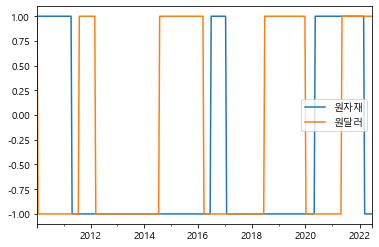

In [ ]:
all_regime_data.plot()

In [ ]:
a=regime_analyze(all_regime_data,sectors)

알파찾기 시작합니다.
1950 1950


In [ ]:
factor1='원자재'
factor2='원달러'

b=a.regime_mix(factor1,factor2)

print(b)



            원자재원달러
2010-01-08       0
2010-01-22       1
2010-02-05       1
2010-02-19       1
2010-03-05       1
...            ...
2022-04-29       2
2022-05-13       2
2022-05-27       2
2022-06-10       2
2022-06-24       2

[326 rows x 1 columns]


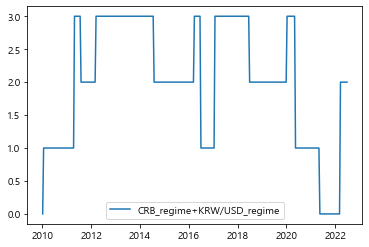

In [ ]:
plt.plot(b,label='CRB_regime+KRW/USD_regime')
plt.legend()

In [ ]:

# 다음과 같이 국면이 섞여 0(상승.상승),1(상승.하락),2(하락.상승),3(하락.하락) 으로 나타나진 것을 볼 수 있습니다.
a.regime_sys_data.loc['2015':]


,원자재원달러
2015-01-02,2
2015-01-16,2
2015-01-30,2
2015-02-13,2
2015-02-27,2
...,...
2022-04-29,2
2022-05-13,2
2022-05-27,2
2022-06-10,2


In [ ]:

last=a.put(sectors,factor1,factor2,'2010')


시작
국면 1 의 개수는 23개 입니다. 
국면 2 의 개수는 74개 입니다. 
국면 3 의 개수는 107개 입니다. 
국면 4 의 개수는 122개 입니다. 


## 원점에서 멀어질수록 초과수익률이 더 높은 섹터입니다.

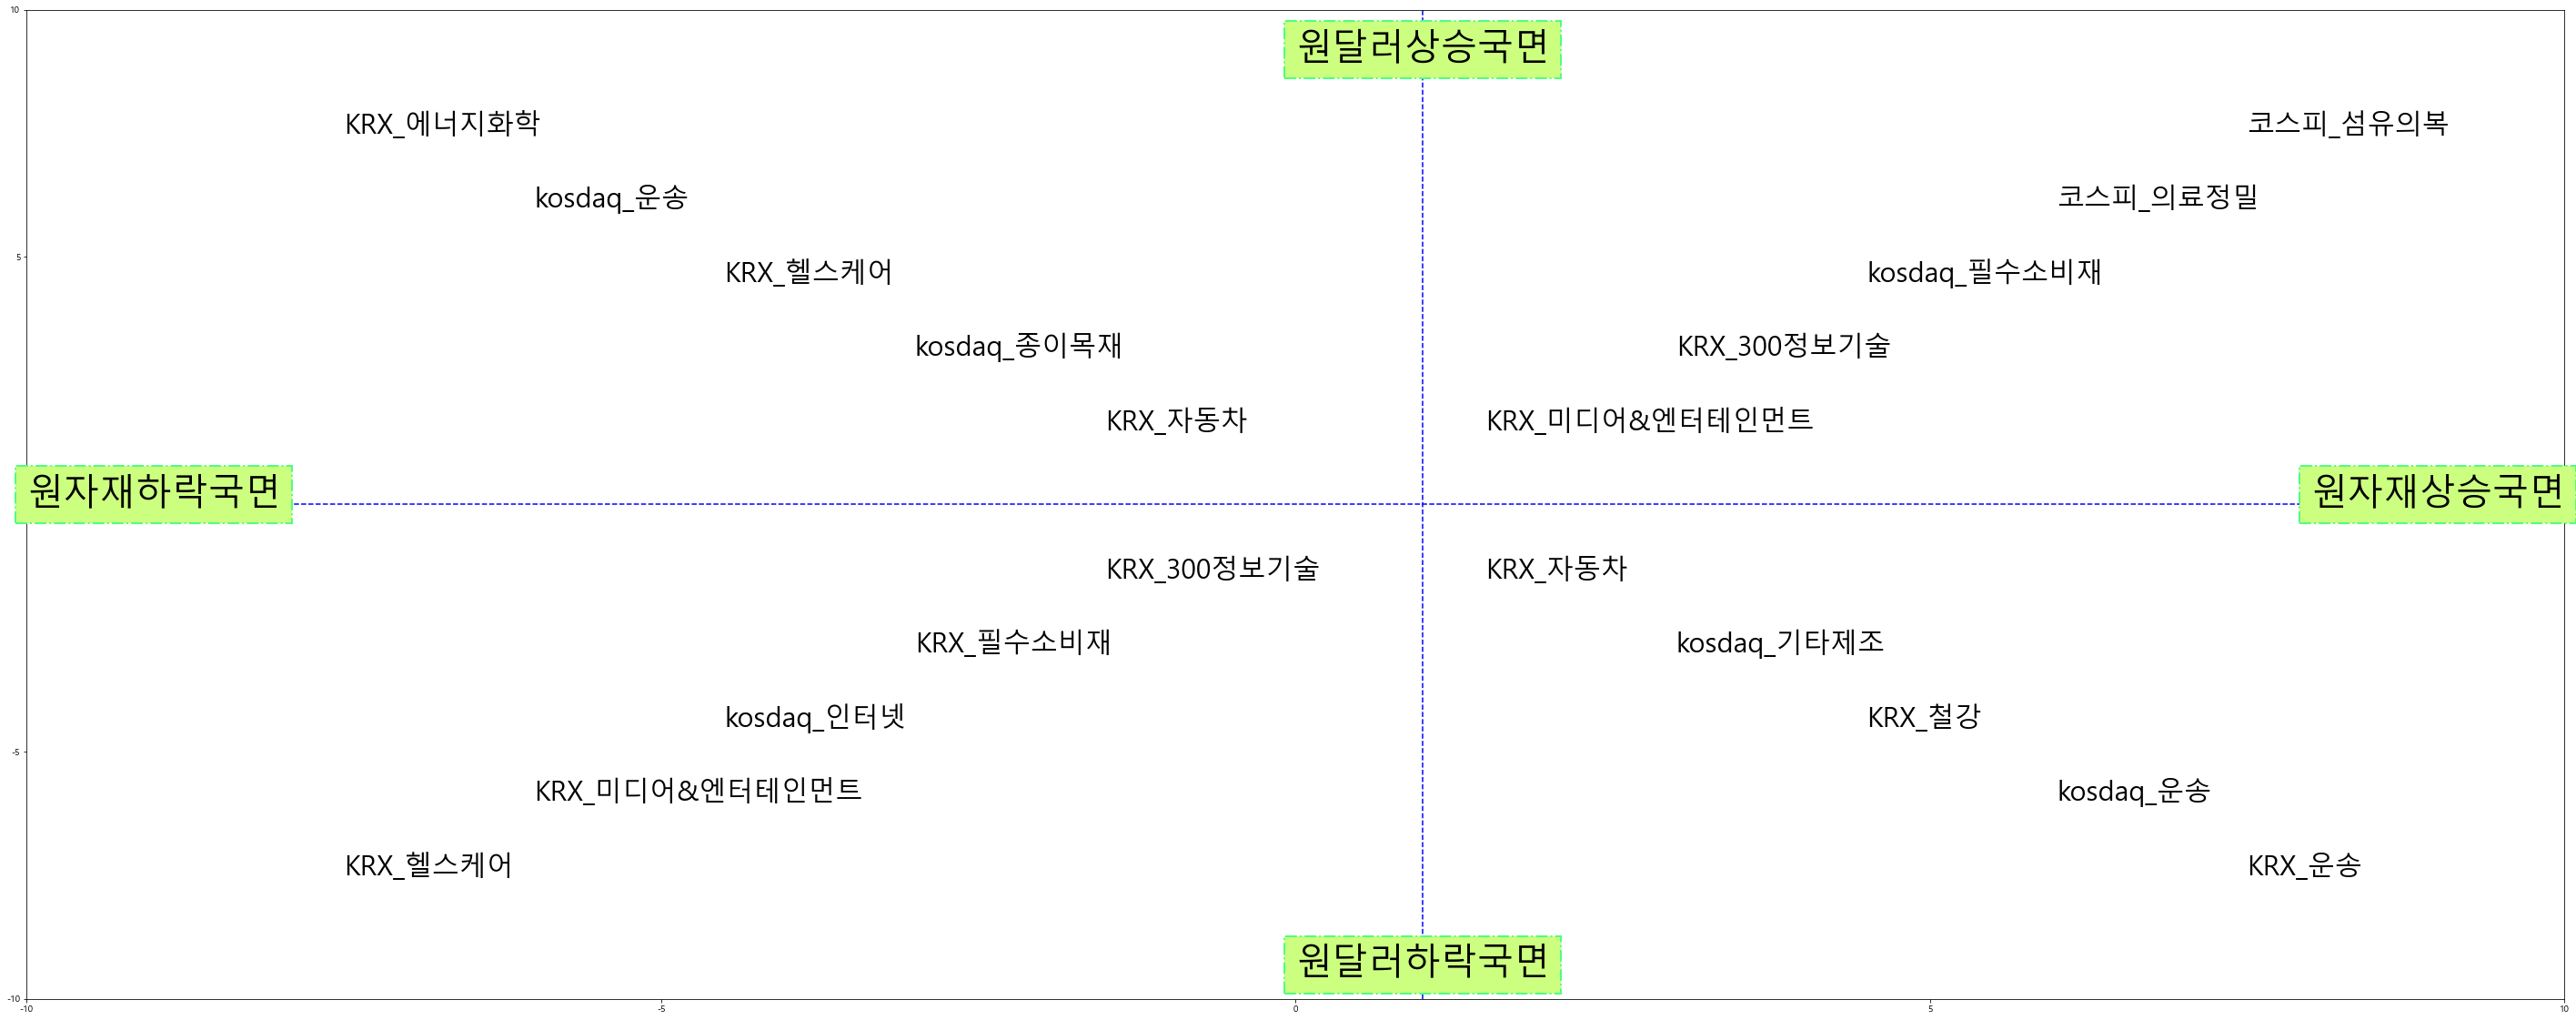

In [ ]:
# 한글이 꺠질경우 다음의 코드를 실행하십시오

plt.rcParams['font.family'] ='Malgun Gothic'


plt.rcParams['axes.unicode_minus'] =False

# 6은 각 국면마다 상위 6개를 뽑아오게 하기 위함입니다.     

a.draw(last,5,factor1,factor2)


## 본 코드는 구리와 원달러의 국면으로 이루어진 예시코드이며, 다양한 변수로 활용될 수 있기에 
## 개인투자자들이 원하는 변수를 입력하여 어떤 주식이 과거에 통계적으로 아웃퍼폼하였는지 관찰할 수 있는 시스템을 구축해보았습니다.

## 다음은 실제로 국면을 활용하여 투자시 어느정도 효과를 보는지 알기 위해 백테스팅 코드를 작성해보았습니다.
## sector_find 함수는 in-sample 데이터에서 국면데이터를 활용해 국면을 나눈뒤 아웃퍼폼 섹터를 찾아주는 함수입니다.
## 2주마다 다음 국면을 예측한 뒤, 해당 국면에 가장 수익률이 통계적으로 좋았던 섹터 5개의 수익률을 비교해보았습니다.

In [ ]:
backtest_data=a.sector_find('원자재','원달러','2015-01-02',5,2) # 2018-01-12

이미 있습니다.
국면 1 의 개수는 1개 입니다. 
국면 2 의 개수는 33개 입니다. 
국면 3 의 개수는 28개 입니다. 
국면 4 의 개수는 69개 입니다. 
날짜 :  2015-01-02 00:00:00
날짜 :  2015-01-16 00:00:00
날짜 :  2015-01-30 00:00:00
날짜 :  2015-02-13 00:00:00
날짜 :  2015-02-27 00:00:00
날짜 :  2015-03-13 00:00:00
날짜 :  2015-03-27 00:00:00
날짜 :  2015-04-10 00:00:00
날짜 :  2015-04-24 00:00:00
날짜 :  2015-05-08 00:00:00
날짜 :  2015-05-22 00:00:00
날짜 :  2015-06-05 00:00:00
날짜 :  2015-06-19 00:00:00
날짜 :  2015-07-03 00:00:00
날짜 :  2015-07-17 00:00:00
날짜 :  2015-07-31 00:00:00
날짜 :  2015-08-14 00:00:00
날짜 :  2015-08-28 00:00:00
날짜 :  2015-09-11 00:00:00
날짜 :  2015-09-25 00:00:00
날짜 :  2015-10-09 00:00:00
날짜 :  2015-10-23 00:00:00
날짜 :  2015-11-06 00:00:00
날짜 :  2015-11-20 00:00:00
날짜 :  2015-12-04 00:00:00
날짜 :  2015-12-18 00:00:00
날짜 :  2016-01-01 00:00:00
날짜 :  2016-01-15 00:00:00
날짜 :  2016-01-29 00:00:00
날짜 :  2016-02-12 00:00:00
날짜 :  2016-02-26 00:00:00
날짜 :  2016-03-11 00:00:00
날짜 :  2016-03-25 00:00:00
날짜 :  2016-04-08 00:00:00
날짜 :  2016-04-22 00:00:0

## 다음과 같이 15년도 1월부터 투자할경우 국면에 따라 아웃퍼폼 상위 업종 5개를 2주마다 뽑았습니다. 해당 섹터는 15년도 이전 국면에서 아웃퍼폼했던 섹터를 매수하는 방식이므로 사후관찰편향을 제거했다고 보시면 되겠습니다.

In [ ]:
backtest_data

,0,1,2,3,4
2015-01-02,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-01-16,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-01-30,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-02-13,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-02-27,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
...,...,...,...,...,...
2022-04-15,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2022-04-29,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2022-05-13,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2022-05-27,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차


In [ ]:
# 데이터를 백업해둡니다.
backtest_data.to_csv('backtest_data_minus.csv')

In [ ]:
index_total = pd.read_csv('0715 섹터 종가.csv', index_col=0, encoding='cp949')
index_total.index = pd.to_datetime((index_total.index))
sectors = index_total.iloc[:,:-1]
sectors.columns=[i.replace('종가','').replace(" ",'') for i in list(sectors.columns)]

## 백테스팅 함수는 위에서 만든 날짜별 섹터를 입력하면 자동으로 close_data 에서 종가를 가져와 수익률을 날짜마다 구해서 데이터프레임화 시킵니다.

In [ ]:
close_data_sector=sector_origin.asfreq('B').ffill()

In [ ]:
def backtesting(df,close_data,market):
    
    #ror_dict = dict()
    df_ror=[0]
    df_bench=[0]
    height = df.shape[0]
    width = df.shape[1]
    
    dates = df.index
    
#     print(height)



    stock_list=['KS11','KQ11','KRX100']
    for index,stock in enumerate(stock_list):

        #stock_data=fdr.DataReader(stock,start)
        stock_data=wb.DataReader(stock, '2002')
        close=stock_data.loc[:,'Close']
        Volume=stock_data.loc[:,'Volume']
        #stock_data.columns=[stock+"Close",stock+"Volume"]
        if index==0:
            close_data1=pd.DataFrame(close)
            vol_data=pd.DataFrame(Volume)
        else:
            close_data1=pd.concat([close_data1,pd.DataFrame(close)],axis=1)
            vol_data=pd.concat([vol_data,pd.DataFrame(Volume)],axis=1)
    close_data1.index=pd.to_datetime(close_data1.index)
    close_data1.columns=['코스피','코스닥','KRX']



    bench_data=close_data1.asfreq('B').ffill()
        
    
    
    
    for i in range(height-1):

        temp_df = df.iloc[i,:]

        start_date = dates[i]
        end_date = dates[i+1]

        ror_list=[]
        for j in range(width):
            ror=0

            ticker = temp_df[j]
            
            buy_close = close_data_sector.loc[start_date,ticker]

            sell_close= close_data_sector.loc[end_date,ticker]
            
            
            buy_bench=bench_data.loc[start_date,market]
            sell_bench=bench_data.loc[end_date,market]

            ror_list.append( (sell_close - buy_close)/buy_close  )
                
            ror1 = (sell_bench-buy_bench)/buy_bench
            
        avg_ror=np.average(ror_list)
        
                        
                        
        df_bench.append(ror1)
        df_ror.append(avg_ror)
    
    
    
    df_ror=pd.DataFrame(df_ror)
    df_ror.index=dates[:]
    df_bench=pd.DataFrame(df_bench)
    df_bench.index=dates[:]
    return df_ror,df_bench




In [ ]:
yy,yy_bench = backtesting(backtest_data.iloc[:,:],sectors,'KRX')    
yy

KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.026402568584190024
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.03651460494314124
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.058510336846246444
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.03413458349474521
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.03451148570862369
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.07226779014436771
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.09609776807195794
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.03271055497562396
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.01959689192173466
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.05364813417289153
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.04456774320632408
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.04947682161414559
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.029571199141466286
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.0005785213627582276
KRX_에너지화학
kosdaq_운송
KRX_헬스

KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.04912921082047819
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.031040278894626898
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.015364864425026575
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.03733076120381409
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.04282013574480008
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.00063676135732402
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
0.00018808723335804294
KRX_에너지화학
kosdaq_운송
KRX_헬스케어
kosdaq_종이목재
KRX_자동차
-0.025790167045945243
KRX_헬스케어
KRX_미디어&엔터테인먼트
kosdaq_인터넷
KRX_필수소비재
KRX_300정보기술
0.008439852395763406
KRX_헬스케어
KRX_미디어&엔터테인먼트
kosdaq_인터넷
KRX_필수소비재
KRX_300정보기술
-0.004139795115020999
KRX_헬스케어
KRX_미디어&엔터테인먼트
kosdaq_인터넷
KRX_필수소비재
KRX_300정보기술
-0.007508091904864692
KRX_헬스케어
KRX_미디어&엔터테인먼트
kosdaq_인터넷
KRX_필수소비재
KRX_300정보기술
-0.043360976542090104
KRX_헬스케어
KRX_미디어&엔터테인먼트
kosdaq_인터넷
KRX_필수소비재
KRX_300정보기술
-0.18455350194675577
KRX_헬스케어
KRX_미디어&엔터테인먼트
kosdaq_인터넷
KRX_필수소비재
KRX_300정보기술
0.156201

,0
2015-01-02,0.000000
2015-01-16,0.026403
2015-01-30,0.036515
2015-02-13,0.058510
2015-02-27,0.034135
...,...
2022-04-15,0.001784
2022-04-29,0.009636
2022-05-13,-0.015151
2022-05-27,0.028888


## yy_bench 는 KRX 지수의 수익률이며, yy는 국면을 활용 하였을때의 수익률입니다.
## 히스토그램과 다양한 통계적 분포를 살펴본 결과, 수익률 및 위험도가 개선된 형태를 나타내는 결과를 보입니다.
## 이는 물론 21년 1월 구리 원달러 국면 기준이며, 투자자가 더욱 다양한 국면을 활용하여 투자 백테스팅을 해볼 수 있음을 기대합니다.

In [ ]:
yy_bench=pd.DataFrame(yy_bench[1:])
yy_bench.columns=['benchmark']

yy=pd.DataFrame(yy[1:])
yy.columns=['model']



## 수익률의 분포를 비교해보았습니다. 벤치마크는 KRX 100 지수로 산출하였습니다.

In [ ]:
pd.concat([yy_bench.describe(),yy.describe()],axis=1)

,benchmark,model
count,193.000000,194.000000
mean,0.002199,0.009582
std,0.034013,0.037135
min,-0.223370,-0.184554
25%,-0.014858,-0.009719
50%,0.001473,0.009397
75%,0.018743,0.030820
max,0.133997,0.156202


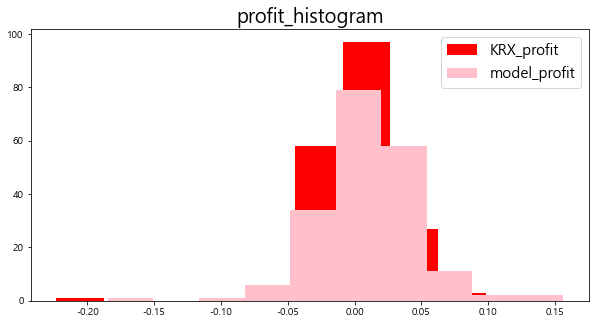

In [ ]:
# 수익률 분포 시각화
plt.figure(figsize=(10,5))
plt.hist(yy_bench[1:],color='red',label='KRX_profit')

plt.hist(yy[1:],color='pink',label='model_profit')
plt.title('profit_histogram',fontsize=20)
plt.legend(fontsize=15)
plt.show()

## 다음은 백테스팅시 실제 금액이 어떻게 변동되는지 관찰하였습니다.

In [ ]:
#수익률 담은 리스트를 이용하여 1000원으로 시작시 변동되는 투자금액을 money_list에 담습니다. (벤치마크의 경우 bench_money_list)
money=1000
bench_money=1000
money_list=[]
bench_money_list=[]

for i , j in zip(yy.values,yy_bench.values):
    
    money*=(1+i)
    bench_money*=(1+j)
    
    money_list.append(money[0])
    bench_money_list.append(bench_money[0])
    #print(money)

## 실제 투자시 투자금액의 변동양상입니다.
## 완벽한 벡테스팅은 아니지만, 국면에 맞는 섹터로만 장기간 투자시에도 벤치마크보다 유의미한 수익률을 거둘 수 있음을 볼 수 있었습니다.

In [ ]:
backtest_data

,0,1,2,3,4
2015-01-02,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-01-16,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-01-30,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-02-13,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2015-02-27,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
...,...,...,...,...,...
2022-04-15,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2022-04-29,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2022-05-13,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차
2022-05-27,KRX_에너지화학,kosdaq_운송,KRX_헬스케어,kosdaq_종이목재,KRX_자동차


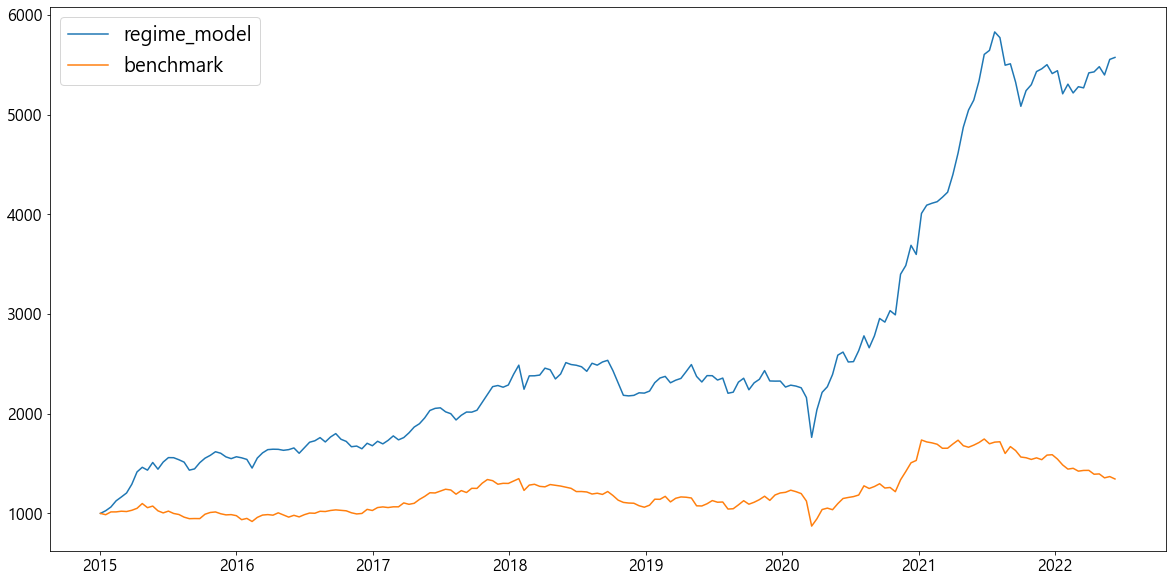

In [ ]:
test=pd.DataFrame(money_list)
bench=pd.DataFrame(bench_money_list)
test.index=yy_bench.index
bench.index=yy_bench.index
plt.figure(figsize=(20, 10))
plt.plot(test,label='regime_model')
plt.plot(bench,label = 'benchmark')
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)

plt.legend(fontsize=20)

## 다음으로는 해당 섹터랑 시중의 어떤 ETF가 유사한지 비교를 해주는 코드입니다.

In [ ]:
# 출처 : https://wendys.tistory.com/180 / 네이버 금융 ETF 종목 크롤링 코드
import requests
import json 
from pandas.io.json import json_normalize 
url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df = json_normalize(json_data['result']['etfItemList'])


In [ ]:
# 시중의 ETF의 가격데이터를 전부 저장해주는 코드입니다. 해당 코드는 시간이 다소 걸리기에 따로 파일을 첨부해두었습니다.
# 파일명 : korea_ETF_data.csv
'''
ETF_frame=pd.DataFrame()

for index,i in enumerate(df.itemcode.values):
    print(index,len(df.itemcode.values))
    stock_D = stock.get_etf_ohlcv_by_date("20200104", "20220805", i).종가

    ETF_frame=ETF_frame.append(stock_D)

ETF_frame.index=df.itemcode.values
ETF_frame=ETF_frame.T
ETF_frame.to_csv('korea_ETF_data.csv')

'''

0 598
1 598
2 598
3 598
4 598
5 598
6 598
7 598
8 598
9 598
10 598
11 598



KeyboardInterrupt



In [ ]:
ETF_frame=pd.read_csv('korea_ETF_data.csv',index_col=0)

In [ ]:
ETF_frame
header= ETF_frame.index.tolist()
H= list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), header))
ETF_frame.index= H


In [ ]:
ETF_pct=ETF_frame.pct_change()
ETF_pct=ETF_pct.loc[:'2022-06-30',:]

In [ ]:
ETF_pct

,069500,371460,122630,133690,102110,252670,360750,157450,214980,381180,...,287300,334700,301400,285020,315480,252720,284990,287320,287330,287310
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.010091,NaN,0.019870,0.009805,0.009392,-0.021193,NaN,0.000050,0.000049,NaN,...,0.007038,-0.003083,0.018163,0.002299,0.020174,0.007440,0.003849,0.000000,0.028659,0.010514
2020-01-08,-0.006434,NaN,-0.011335,-0.002050,-0.006429,0.014435,NaN,0.000000,0.000000,NaN,...,-0.037097,-0.022263,-0.033201,-0.019113,-0.008539,-0.012163,-0.037700,-0.024915,-0.016005,-0.018497
2020-01-09,0.016701,NaN,0.031530,0.004649,0.016516,-0.033992,NaN,0.000150,0.000098,NaN,...,0.012842,-0.028463,0.039979,0.000779,0.007253,0.012753,0.006640,0.006388,-0.001807,-0.002945
2020-01-10,0.008213,NaN,0.017714,0.012267,0.008040,-0.017185,NaN,0.000050,0.000049,NaN,...,0.009923,0.013672,0.012321,0.007009,0.007651,0.003474,0.017150,0.005193,0.012070,0.003544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,0.021051,0.020904,0.042802,0.023414,0.020016,-0.041359,0.017101,0.000099,-0.000048,0.007654,...,0.034024,0.012448,0.048123,0.028140,0.041209,0.022613,0.009461,0.020056,0.016393,0.014396
2022-06-27,0.012786,-0.003320,0.023066,0.015519,0.012444,-0.024653,0.014011,0.000000,0.000048,0.019533,...,0.029306,-0.035861,0.018365,0.011348,-0.006785,0.001229,0.007498,0.015089,0.018433,0.036026
2022-06-28,0.007732,0.008329,0.015915,-0.004161,0.008352,-0.015798,0.000000,0.000050,-0.000096,0.004790,...,0.019481,0.014878,-0.007665,0.002640,-0.005313,0.005726,0.020930,0.021622,0.000754,0.010537
2022-06-29,-0.016755,-0.031938,-0.032637,-0.023487,-0.015940,0.032103,-0.011844,-0.000050,-0.000193,-0.021716,...,-0.004410,-0.003141,-0.017719,-0.024358,-0.023274,-0.010980,-0.020501,-0.002646,0.011304,-0.032847


In [ ]:
energy=sectors.KRX_에너지화학.loc[ETF_pct.index]

In [ ]:
energy

2020-01-06    2003.65
2020-01-07    2006.67
2020-01-08    1931.60
2020-01-09    1960.99
2020-01-10    1991.26
               ...   
2022-06-24    3120.94
2022-06-27    3153.50
2022-06-28    3219.27
2022-06-29    3153.15
2022-06-30    3037.26
Name: KRX_에너지화학, Length: 615, dtype: float64

In [ ]:
cor_energy=pd.concat([ETF_pct,energy],axis=1).corr().KRX_에너지화학

In [ ]:
cor_energy

069500      -0.001585
371460       0.028800
122630      -0.000317
133690      -0.017084
102110      -0.001057
               ...   
284990      -0.000196
287320       0.047210
287330       0.000882
287310       0.021314
KRX_에너지화학    1.000000
Name: KRX_에너지화학, Length: 596, dtype: float64

In [ ]:
energy_etf=cor_energy.loc[cor_energy>0.7].index

In [ ]:
print(energy_etf)

Index(['434730', '433220', '433500', 'KRX_에너지화학'], dtype='object')


In [ ]:
df[df['itemcode'].isin(energy_etf)].iloc[:,2:].reset_index(drop=True)

,itemname,nowVal,risefall,changeVal,changeRate,nav,threeMonthEarnRate,quant,amonut,marketSum
0,KINDEX 원자력테마딥서치,12775,2,120,0.95,12805.0,NaN,319014,4087,153
1,HANARO 원자력iSelect,11860,2,220,1.89,11906.0,NaN,75837,901,125
2,에셋플러스 글로벌대장장이액티브,11195,5,-15,-0.13,11246.0,NaN,9794,110,123


## 다음과 같이 해당 섹터지수와 유사한 ETF를 가져올 수 있게 하였습니다.

## 본 프로그램을 통해 거시적 데이터에 따른 국면에서 어떤 섹터들이 아웃퍼폼했는지를 투자자들이 잘 이해하며 투자를 하는데에 있어서 좋은 보조 지표가 될 수 있음을 기대합니다.
## 뿐만 아니라, 국면 테마로 하나의 큰 시스템을 만들어 백테스팅, 유사 ETF의 기본 정보, 적절한 비중 최적화 등 다양한 기능들을 제공하게끔 하여 데이터의 수요를 더욱 끌어올릴 수 있음을 기대합니다. 

## 다음은 각 국면마다 성과가 좋았던 상위 2개 섹터를 이용해서 포트폴리오 최적화 하는 코드입니다.
## 기본적으로 deepdow라는 모듈을 활용해서 딥러닝을 진행하였습니다.
## 참고링크는 다음과 같습니다. (링크 : https://deepdow.readthedocs.io/en/latest/)

In [ ]:
#!pip install deepdow --user
# 국면 없음
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
import matplotlib.pyplot as plt
import numpy as np
import torch , random, datetime
import csv, itertools
import pandas as pd
torch.manual_seed(7)
np.random.seed(7)

# GPU 및 CPU 사용 선택
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

# 데이터 불러오기
df = pd.read_csv('0715 섹터 종가.csv', encoding = 'cp949', index_col = 0)

# 최적화할 자산 추출
df1 = df[['코스피_200 헬스케어 종가', '코스피_의약품 종가', 'kosdaq_종이목재 종가', '코스피_서비스업 종가', '코스피_음식료품 종가', 'KRX_에너지화학 종가', 'KRX_자동차 종가', '코스피_기계 종가', '코스피_200 에너지화학 종가', '코스피_보험 종가', 
          '코스피_통신업 종가', 'KRX_건설 종가', 'KRX_기계장비 종가', 'kosdaq_운송장비부품 종가', '코스피_200 중공업 종가', 'kosdaq_방송서비스 종가', 'kosdaq_자유소비재 종가', '코스피_의료정밀 종가', 'kosdaq_출판매체복제 종가', 'kosdaq_인터넷 종가']]

# 인덱스 datetime 형태로 변형
header= df1.index.tolist()
H= list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), header))
df1.index= H
df1 = df1.iloc[::-1]#.asfreq('w-fri')#.asfreq('B').ffill()
n_assets =len(df1.columns)
n_timesteps=len(df1.index)

# 지수를 일일 변화량으로 변형
returns=np.array(df1.pct_change().dropna())

#def run_model(loss_type,lookback, gap, horizon ,epoch, patience):

n_assets = len(df1.columns)

# 데이터를 모델에 들어갈 형태로 변환 
lookback, gap, horizon = 30, 1, 3
n_samples = n_timesteps - lookback - horizon - gap + 1
X_list, y_list = [], []
for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(returns[i - lookback: i, :])

    y_list.append(returns[i + gap: i + gap + horizon, :])

X = np.stack(X_list[:-2], axis=0)[:, None, ...]
y = np.stack(y_list[:-2], axis=0)[:, None, ...]

# 학습 및 테스트 기간 설정
split_ix = int(n_samples * 0.6)                                
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, X.shape[0]))

# 학습 및 테스트 기간 출력
print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],  indices_test[0], indices_test[-1]))

# 평균 및 표준편차 출력
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

# 데이터 스케일링
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

# 학습 데이터 설정
dataloader_train = RigidDataLoader(dataset,
                                indices=indices_train,
                                batch_size=32)
# 테스트 데이터 설정
dataloader_test = RigidDataLoader(dataset,
                                indices=indices_test,
                                batch_size=32)
# 신경망 구조 설정
class GreatNet(torch.nn.Module, Benchmark):
    def __init__(self, n_assets, lookback, p=0.5):          
        super().__init__()
        self.n_assets=n_assets
        n_features = n_assets * lookback

        self.dropout_layer = torch.nn.Dropout(p=p)
        self.dense_layer = torch.nn.Linear(n_assets, n_assets, bias=True)
        self.dense_layer2 = torch.nn.Linear(n_assets, n_assets, bias=True)

        self.allocate_layer = SoftmaxAllocator(temperature=None)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)

        self.lstm = torch.nn.LSTM(n_assets*lookback, n_assets, 1, batch_first=True)
        self.fc = torch.nn.Linear(n_assets, n_assets)
    def forward(self, x):                       
        n_samples, _, _, _ = x.shape
        x = x.view(n_samples, -1)  
        h0 = torch.zeros(1,n_assets )
        c0 = torch.zeros(1, n_assets) 
        out, _ = self.lstm(x, (h0, c0)) 
        x = out
        x = self.dropout_layer(x)
        x = self.dense_layer(x)
        x = self.dense_layer2(x)
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature
        weights = self.allocate_layer(x, temperatures)
        return weights


# 신경망 생성
network = GreatNet(n_assets, lookback )
network = network.train() 

# 손실함수 정의
loss = MaximumDrawdown()

# 모델 훈련 및 테스트 데이터로 검증
run = Run(network,
      loss,
      dataloader_train,
      val_dataloaders={'test': dataloader_test},
      optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
      callbacks=[EarlyStoppingCallback(metric_name='loss',      dataloader_name='test',  patience=5)])

# 에포크 20회 동안 학습
history = run.launch(20)

# 결과 데이터 정렬
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']


# 모델 검증
network = network.eval()

# 검증 모델 생성
benchmarks = {'Equal': OneOverN(),  'Optimal': network}

# 검증 지표 생성
metrics = {'MaxDD': MaximumDrawdown(),'Sharpe': SharpeRatio(),'MeanReturn': MeanReturns()}



False
학습을 진행하는 기기: cpu
Train range: 0:1628
Test range: 1662:2712
mean: [0.00031009], std: [0.01659429]


Epoch 10: 100%|███████████████████████████████████████| 51/51 [00:01<00:00, 29.96it/s, loss=0.00405, test_loss=0.00782]


Training interrupted
Training stopped early because there was no improvement in test_loss for 5 epochs


<AxesSubplot:xlabel='epoch'>

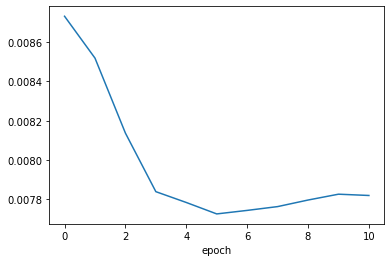

In [ ]:
# 테스트 데이터의 Loss값 이미지 출력

per_epoch_results.mean()['test']['loss']['network'].plot()

array([<AxesSubplot:title={'center':'MaxDD'}, xlabel='timestamp'>,
       <AxesSubplot:title={'center':'Sharpe'}, xlabel='timestamp'>,
       <AxesSubplot:title={'center':'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

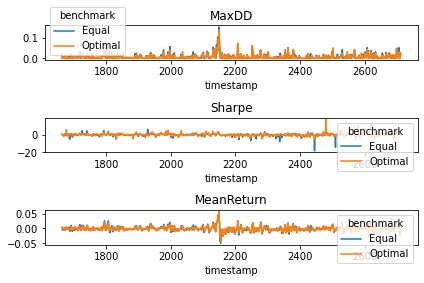

In [ ]:

# 테스트 데이터를 검증 지표 및 검증 모델별로 정리
metrics_table = generate_metrics_table(benchmarks,  dataloader_test, metrics)

# 검증 지표별로 결과값 비교 이미지화
plot_metrics(metrics_table)

In [ ]:

# 검증 지표 및 검증 지표별로 결과값 출력
print('Optimal MDD',metrics_table.loc[(metrics_table.benchmark=='Optimal')&(metrics_table.metric=='MaxDD')].value.describe())
print('Equal MDD',metrics_table.loc[(metrics_table.benchmark=='Equal')&(metrics_table.metric=='MaxDD')].value.describe())
print('Optimal Sharpe',metrics_table.loc[(metrics_table.benchmark=='Optimal')&(metrics_table.metric=='Sharpe')].value.describe())
print('Equal sharpe', metrics_table.loc[(metrics_table.benchmark=='Equal')&(metrics_table.metric=='Sharpe')].value.describe())
print('Optimal Return',metrics_table.loc[(metrics_table.benchmark=='Optimal')&(metrics_table.metric=='MeanReturn')].value.describe())
print('Equal Return', metrics_table.loc[(metrics_table.benchmark=='Equal')&(metrics_table.metric=='MeanReturn')].value.describe())



Optimal MDD count    1051.000000
mean        0.007868
std         0.011735
min        -0.000000
25%        -0.000000
50%         0.003780
75%         0.011125
max         0.135068
Name: value, dtype: float64
Equal MDD count    1051.000000
mean        0.008863
std         0.013172
min        -0.000000
25%        -0.000000
50%         0.004125
75%         0.012485
max         0.150587
Name: value, dtype: float64
Optimal Sharpe count    1051.000000
mean       -0.067645
std         1.261140
min        -5.534762
25%        -0.594714
50%        -0.081139
75%         0.383301
max        16.932625
Name: value, dtype: float64
Equal sharpe count    1051.000000
mean       -0.198005
std         1.410707
min       -18.251093
25%        -0.668246
50%        -0.131916
75%         0.378433
max        10.961310
Name: value, dtype: float64
Optimal Return count    1051.000000
mean       -0.000080
std         0.007082
min        -0.045229
25%        -0.003738
50%        -0.000542
75%         0.003207
max 